In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [311]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing,SARIMAX,ARIMA
from sklearn.metrics import mean_squared_error

# Sparkling Dataset

## Read the data as an appropriate Time Series data and plot the data.

In [312]:
spark=pd.read_csv('Sparkling.csv')
spark.head()

YearMonth  Sparkling
0   1980-01       1686
1   1980-02       1591
2   1980-03       2304
3   1980-04       1712
4   1980-05       1471

In [313]:
dates=pd.date_range(start='1980-01-01',freq='MS',periods=len(spark))

In [314]:
import calendar
spark['month']=dates.month
spark['month']=spark['month'].apply(lambda x: calendar.month_abbr[x])
spark['year']=dates.year
spark.drop(['YearMonth'],axis=1,inplace=True)

In [315]:
spark.set_index(dates,inplace=True)

In [316]:
spark.head()

Sparkling month  year
1980-01-01       1686   Jan  1980
1980-02-01       1591   Feb  1980
1980-03-01       2304   Mar  1980
1980-04-01       1712   Apr  1980
1980-05-01       1471   May  1980

In [317]:
spark.describe()

Sparkling         year
count   187.000000   187.000000
mean   2402.417112  1987.299465
std    1295.111540     4.514749
min    1070.000000  1980.000000
25%    1605.000000  1983.000000
50%    1874.000000  1987.000000
75%    2549.000000  1991.000000
max    7242.000000  1995.000000

Text(0.5, 1.0, 'Sparkling Wine Sales')

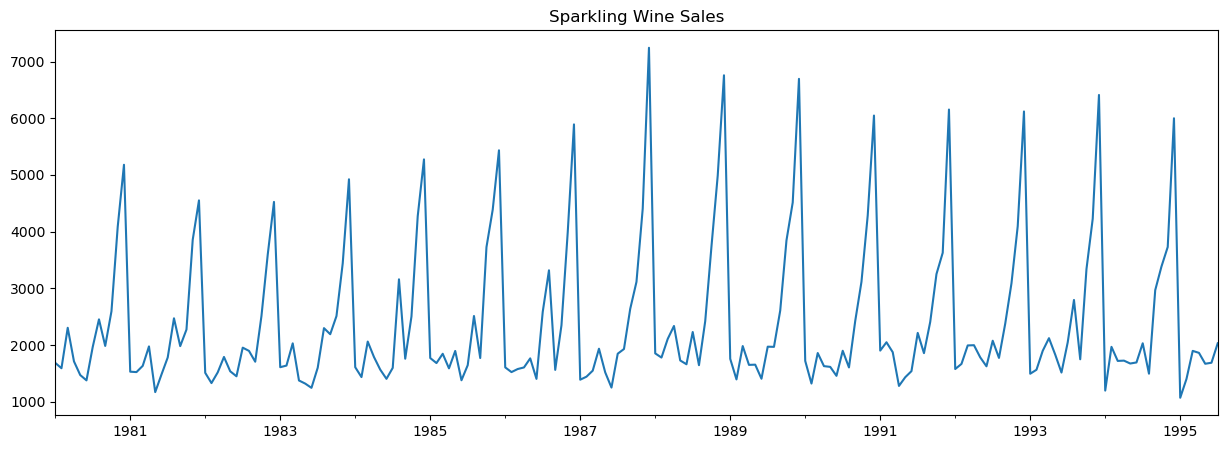

In [318]:
plt.figure(figsize=(15,5))
spark['Sparkling'].plot()
plt.title('Sparkling Wine Sales')

Observations:
- The plot represents the Sparkling wine sales from  Jan 1980 to July 1995, covering a span of 15.5 years- 187 values
- There seems to be some seasonality associated with this plot. 
- The minimum sales was 1070, the maximum sales was 7242, with a mean of 2402
- There are no null values

## Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

### EDA

#### Yearly boxplot

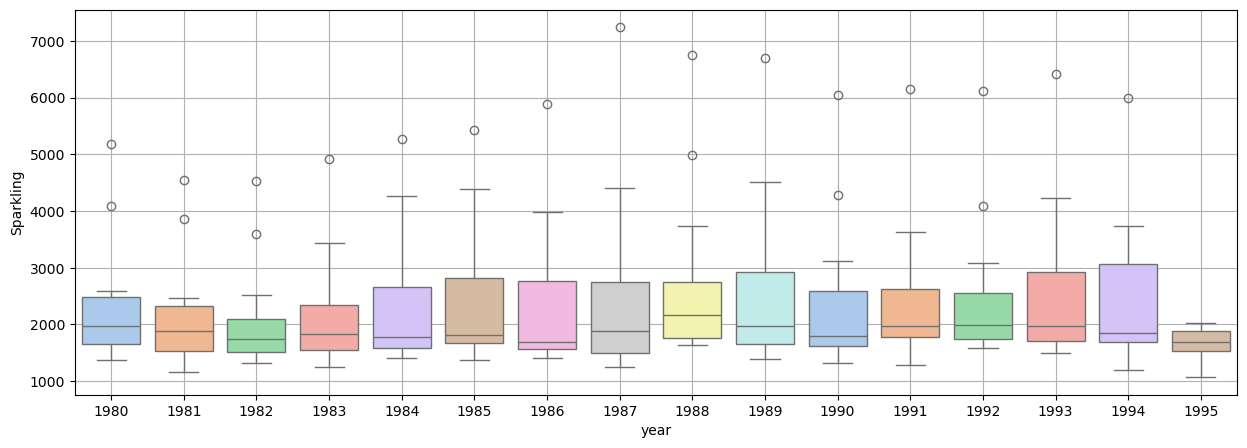

In [319]:
# Trend analysis
plt.figure(figsize=(15,5))
sns.boxplot(x=spark.year,y=spark.Sparkling,palette='pastel',color='blue')
plt.grid();

Observations:
- Unable to discern a tren from the above boxplot.

#### Monthly boxplot

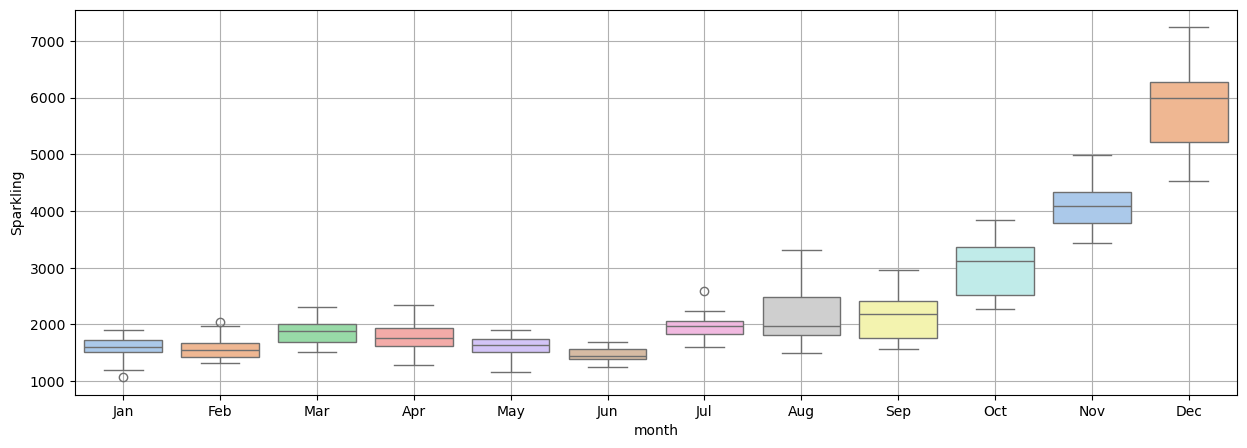

In [320]:
# Seasonality analysis
plt.figure(figsize=(15,5))
sns.boxplot(x=spark.month,y=spark.Sparkling,palette='pastel',color='blue')
plt.grid();

Observations:
- The sales remains low for the first half of the year, and increases in the second half
- Peak sales is in the month of December
- The variability also changes from Jan to Dec. Seasonality is indicated

#### Month-plot

In [321]:
from pylab import rcParams

rcParams['figure.figsize']= 20,8

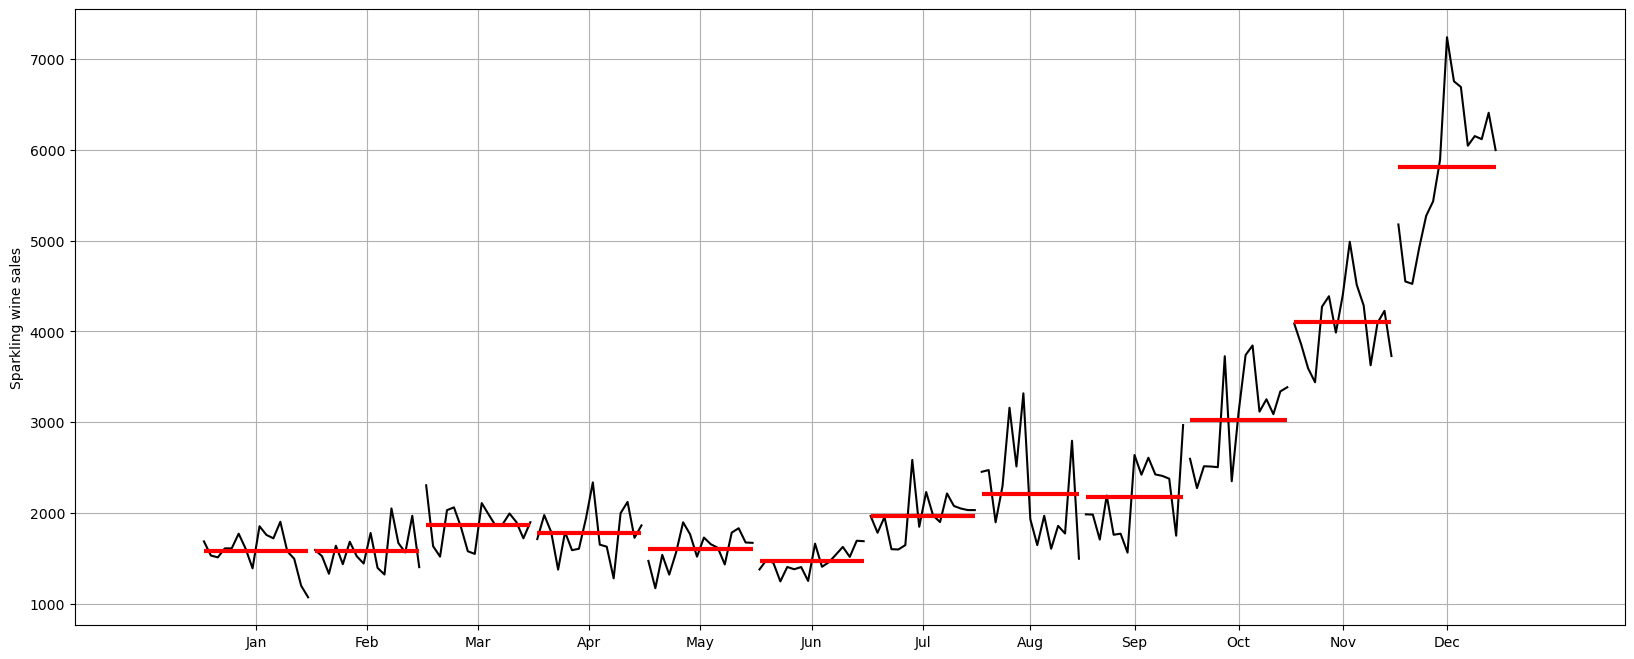

In [322]:
from statsmodels.graphics.tsaplots import month_plot

month_plot(spark['Sparkling'],ylabel='Sparkling wine sales')
plt.grid();

Observations:
- The month plots are not very similar to each other

#### Monthly sales movement

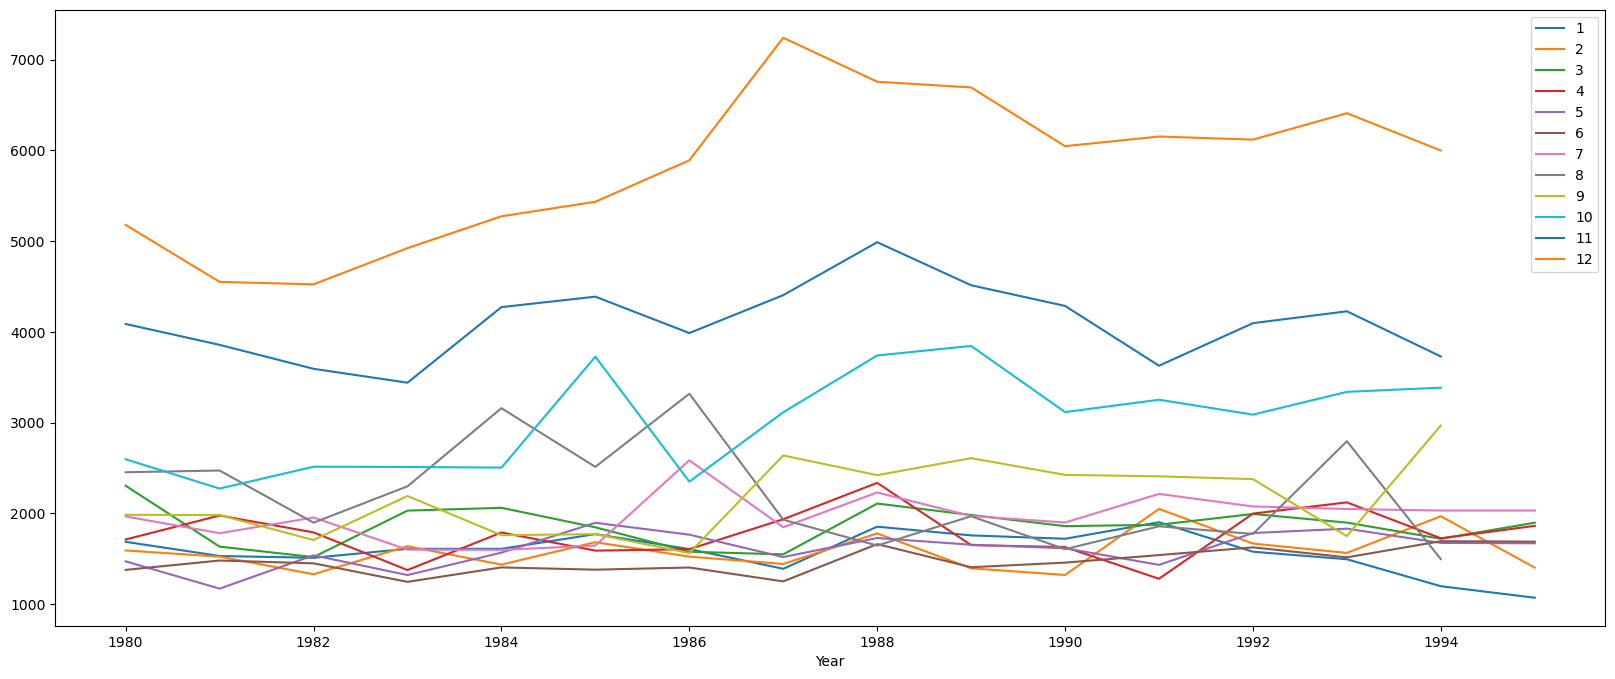

In [323]:
yoy_monthly_sales_movement=pd.pivot_table(spark,values='Sparkling',columns=spark.index.month,index=spark.year)
yoy_monthly_sales_movement.plot()
plt.xlabel('Year')
plt.legend(loc='best')

Observations:
- For the first 9-10 months, the lines intersect
- For the months of November and December, a clear increase in sales is observed

#### Yearly sales movement

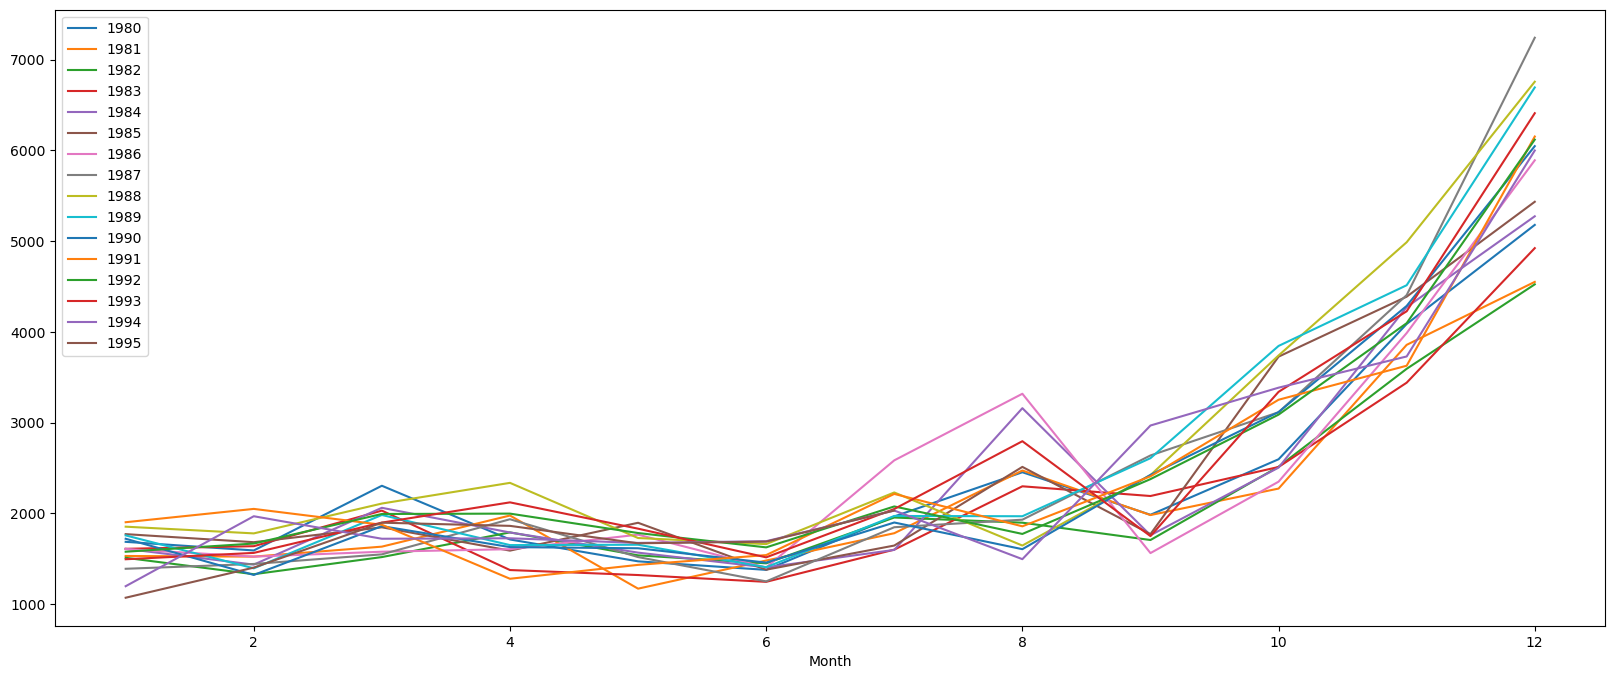

In [324]:
yearly_sales_movement=pd.pivot_table(spark,values='Sparkling',index=spark.index.month,columns=spark.index.year)
yearly_sales_movement.plot()
plt.xlabel('Month')
plt.legend(loc='best')

Observations:
- No clear yoy trend can be discerned
- Once again, the sales remain flat for the first 6 months of the year, and then rise,peaking in November and Deccember

### Decomposition

In [325]:
# additive
sparkling_sales=spark['Sparkling']
add_decompose=seasonal_decompose(sparkling_sales,model='additive')

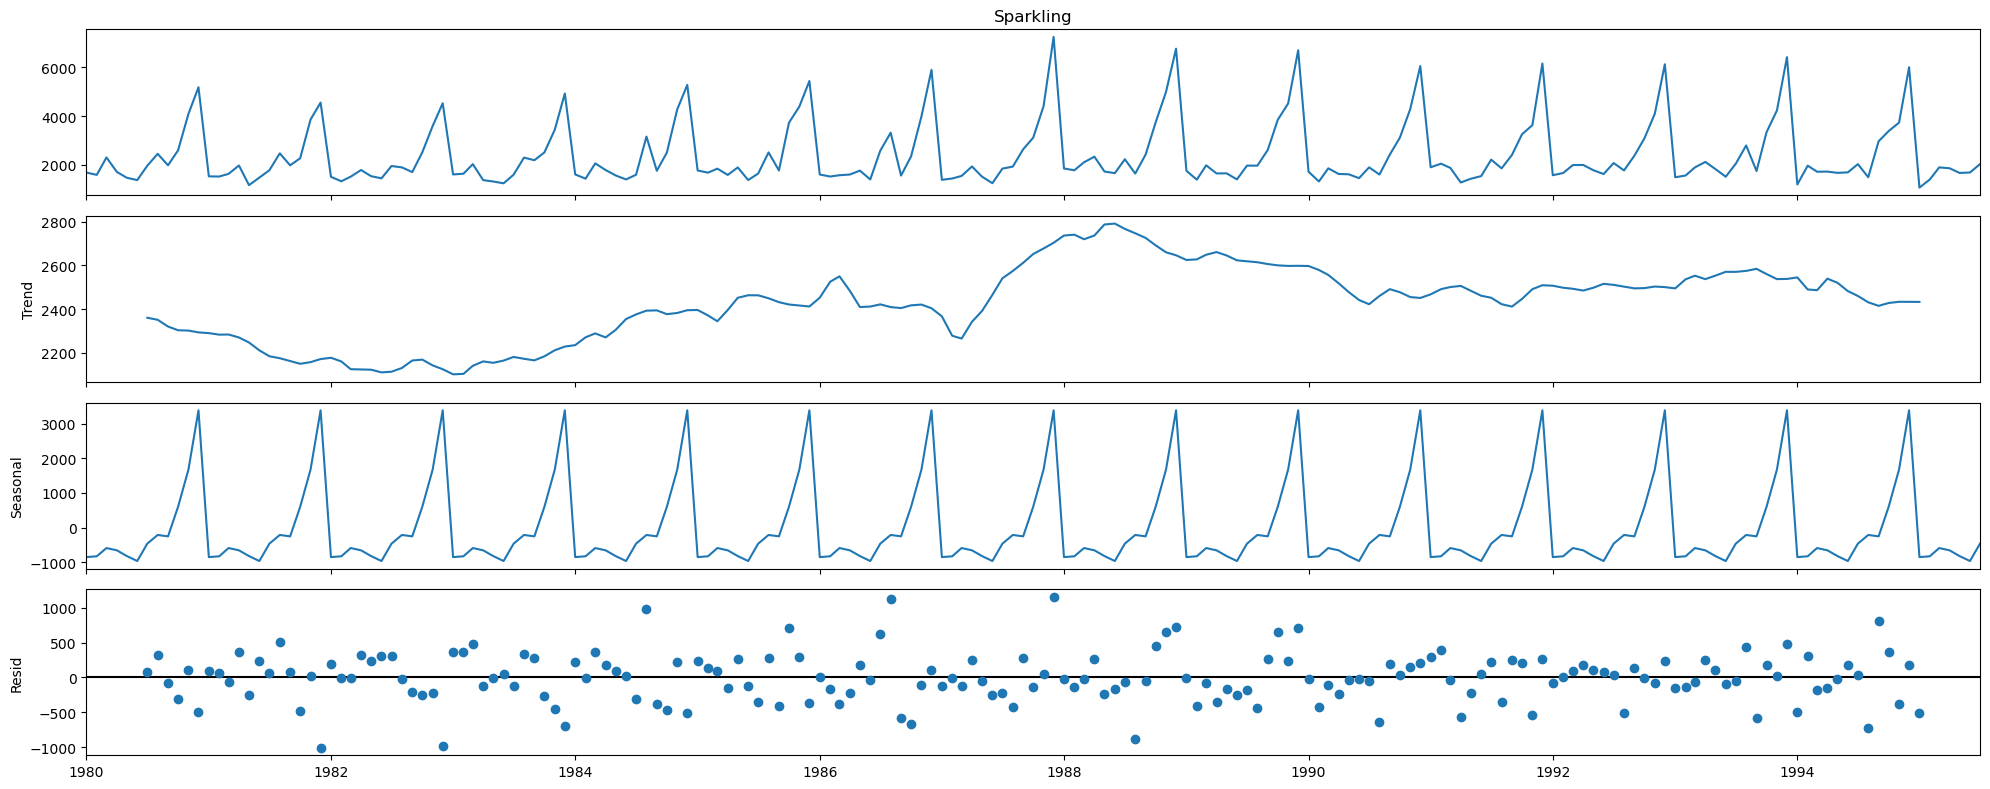

In [326]:
add_decompose.plot();

Observations:
- Clear seasonality component observed
- The residuals are not aligned, and exhibit trend.
- Need to compare with multiplicative seasonality

In [327]:
add_resid=add_decompose.resid

In [328]:
# multiplicative
sparkling_sales=spark['Sparkling']
mul_decompose=seasonal_decompose(sparkling_sales,model='multiplicative')

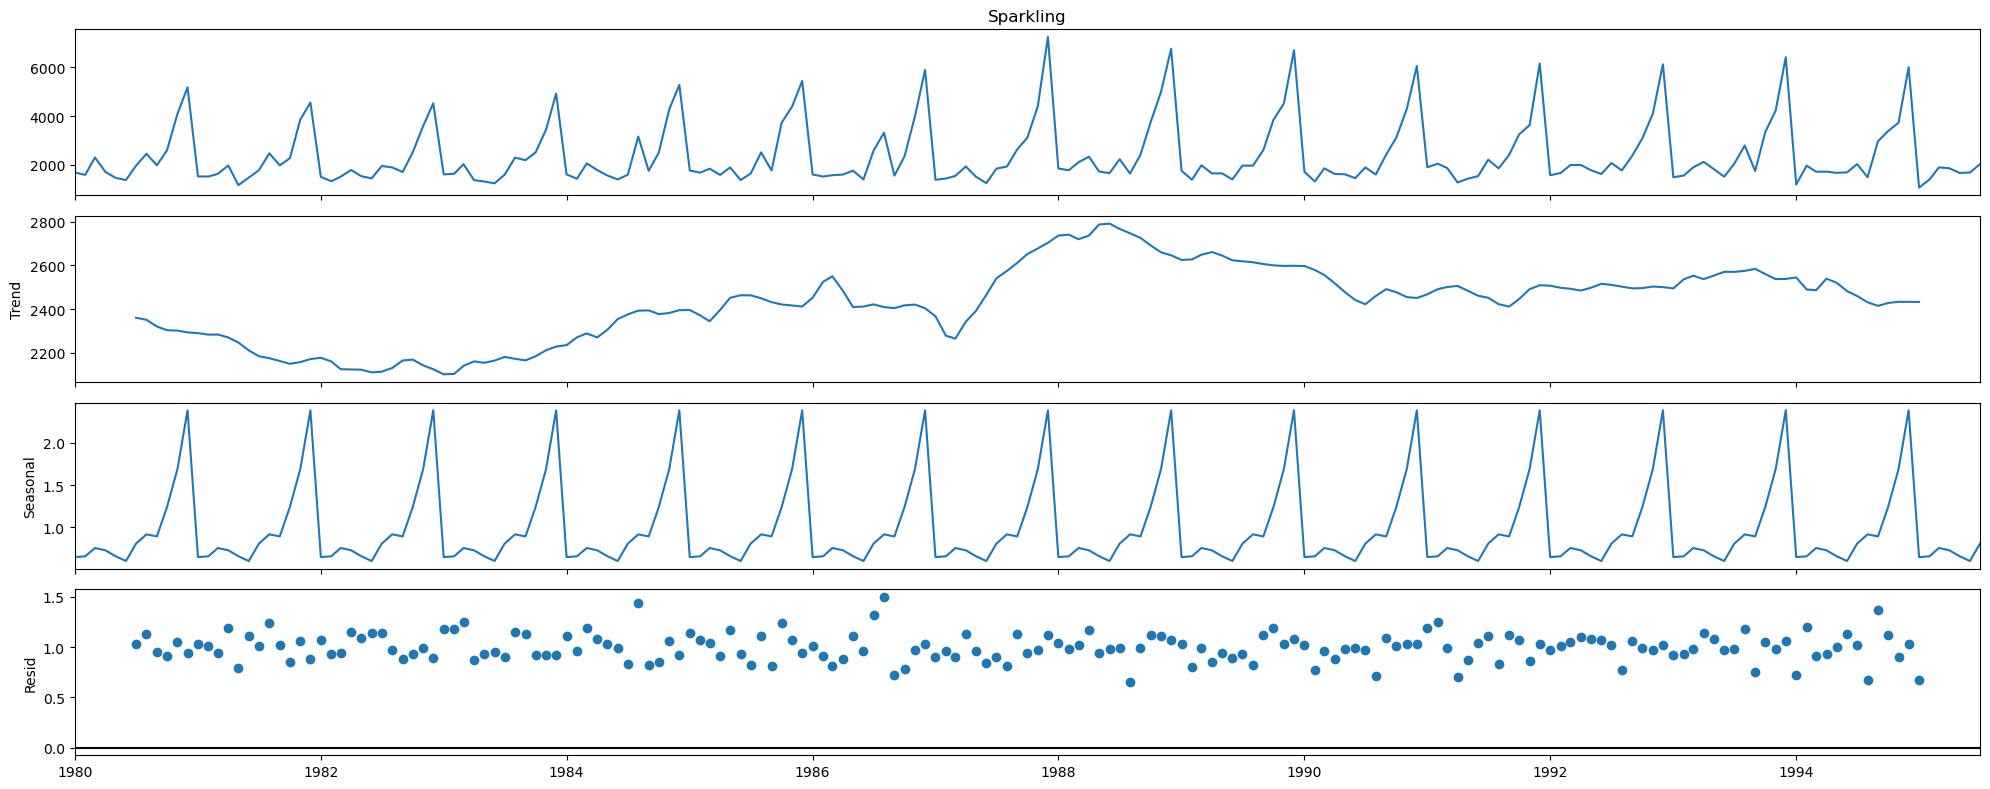

In [329]:
mul_decompose.plot();

Observations:
- The residual plots of both the decompositions look similar. Hence, we can adopt the simpler of the two- additive seasonality.

In [330]:
trend=add_decompose.trend
seasonality=add_decompose.seasonal
resid=add_decompose.resid

print('\nTrend: ', trend.head(12).round(2))
print('\nSeasonality: ', seasonality.head(12).round(2))
print('\nResiduals: ', resid.head(12).round(2))


Trend:  1980-01-01        NaN
1980-02-01        NaN
1980-03-01        NaN
1980-04-01        NaN
1980-05-01        NaN
1980-06-01        NaN
1980-07-01    2360.67
1980-08-01    2351.33
1980-09-01    2320.54
1980-10-01    2303.58
1980-11-01    2302.04
1980-12-01    2293.79
Freq: MS, Name: trend, dtype: float64

Seasonality:  1980-01-01    -854.26
1980-02-01    -830.35
1980-03-01    -592.36
1980-04-01    -658.49
1980-05-01    -824.42
1980-06-01    -967.43
1980-07-01    -465.50
1980-08-01    -214.33
1980-09-01    -254.68
1980-10-01     599.77
1980-11-01    1675.07
1980-12-01    3386.98
Freq: MS, Name: seasonal, dtype: float64

Residuals:  1980-01-01       NaN
1980-02-01       NaN
1980-03-01       NaN
1980-04-01       NaN
1980-05-01       NaN
1980-06-01       NaN
1980-07-01     70.84
1980-08-01    316.00
1980-09-01    -81.86
1980-10-01   -307.35
1980-11-01    109.89
1980-12-01   -501.78
Freq: MS, Name: resid, dtype: float64


## Split the data into training and test. The test data should start in 1991.

In [331]:
spark_df=spark.copy()
##spark_df1=spark_df.drop(['month','year'],axis=1,inplace=True)

In [332]:
spark

Sparkling month  year
1980-01-01       1686   Jan  1980
1980-02-01       1591   Feb  1980
1980-03-01       2304   Mar  1980
1980-04-01       1712   Apr  1980
1980-05-01       1471   May  1980
...               ...   ...   ...
1995-03-01       1897   Mar  1995
1995-04-01       1862   Apr  1995
1995-05-01       1670   May  1995
1995-06-01       1688   Jun  1995
1995-07-01       2031   Jul  1995

[187 rows x 3 columns]

In [333]:
spark_df.drop(['month','year'],axis=1,inplace=True)

In [334]:
spark_df

Sparkling
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

[187 rows x 1 columns]

In [335]:
train=spark_df[spark_df.index.year< 1991]
test=spark_df[spark_df.index.year>= 1991]

In [336]:
train.shape

(132, 1)

In [337]:
test.shape

(55, 1)

In [338]:
train.head()

Sparkling
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [339]:
train.tail()

Sparkling
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047

In [340]:
test.head()

Sparkling
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432

In [341]:
test.tail()

Sparkling
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

## Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.
Note: Stationarity should be checked at alpha = 0.05.

In [342]:
from statsmodels.tsa.stattools import adfuller

In [343]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=12).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

The stationarity of the data can be ascertained by the Dickey-Fuller test. The Null and alternate hypothesis are as follows:
- H0: The series is non-stationary
- Ha: The series is stationary

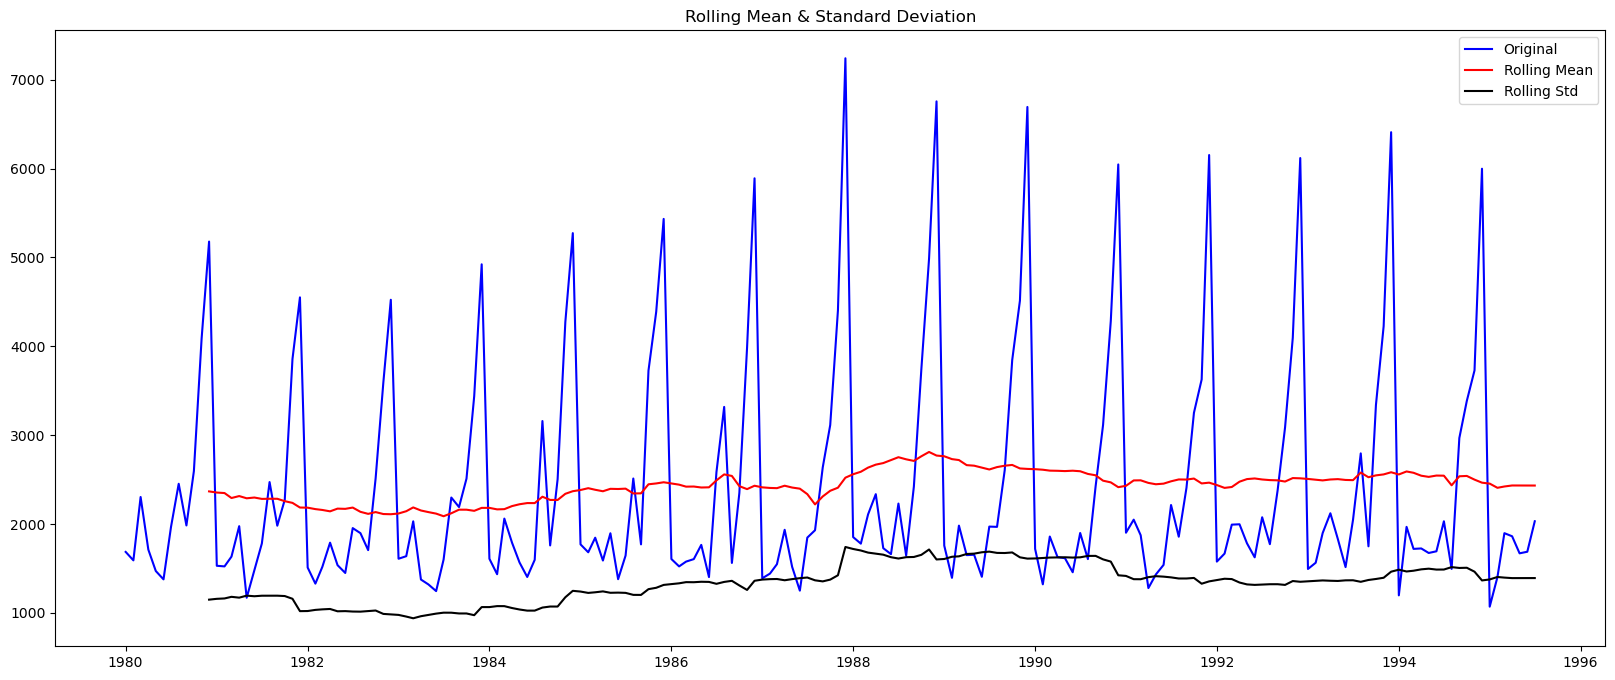

Results of Dickey-Fuller Test:
Test Statistic                  -1.360497
p-value                          0.601061
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [344]:
test_stationarity(sparkling_sales)

Observations:
- Since the p value is greater than alpha(0.05), we fail to reject the null hypothesis. Hence it is established that the series is not stationary.

In [345]:
diff_series=sparkling_sales.diff(periods=1).dropna()
res=adfuller(diff_series)
p_val=res[1]
lags=res[2]

Stationarity of original data


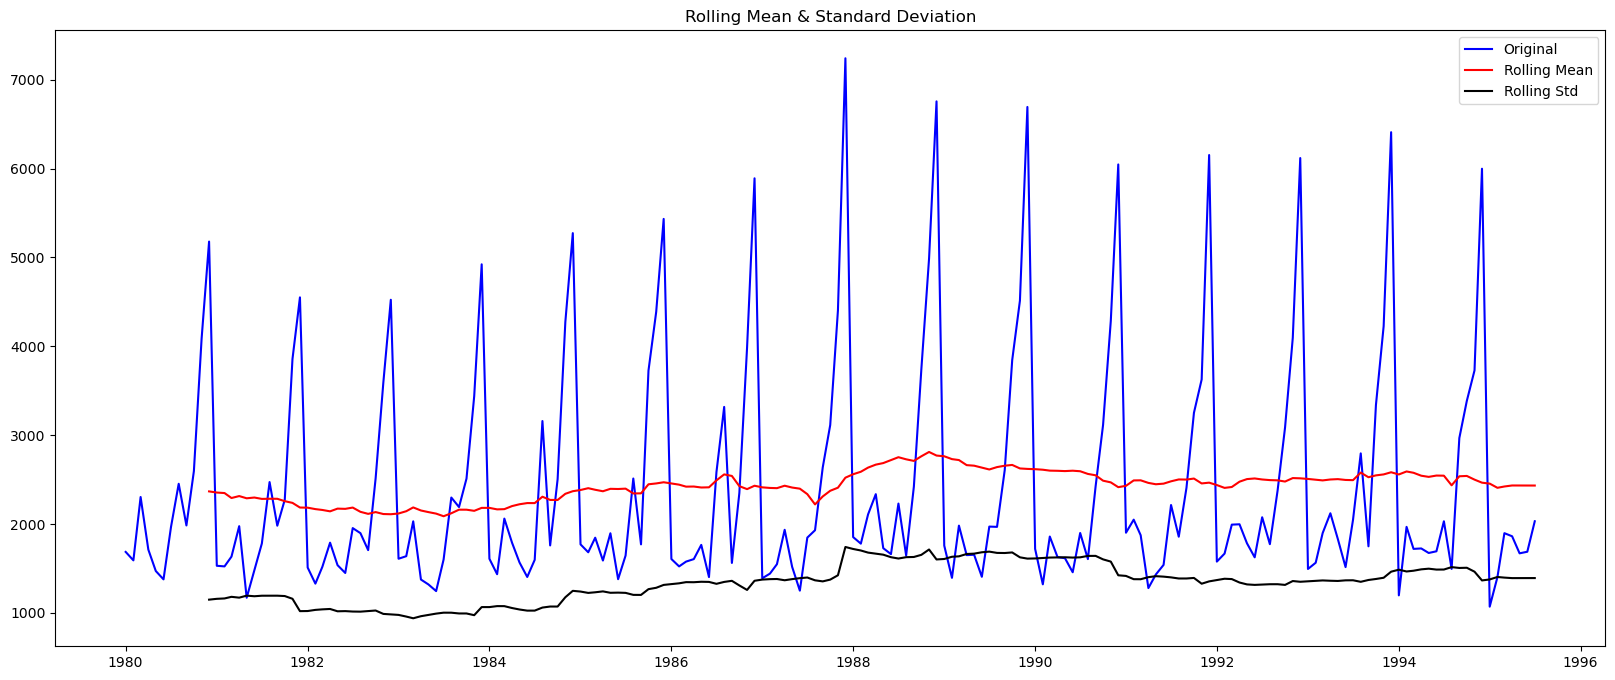

Results of Dickey-Fuller Test:
Test Statistic                  -1.360497
p-value                          0.601061
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 


 Stationarity after first order differencing


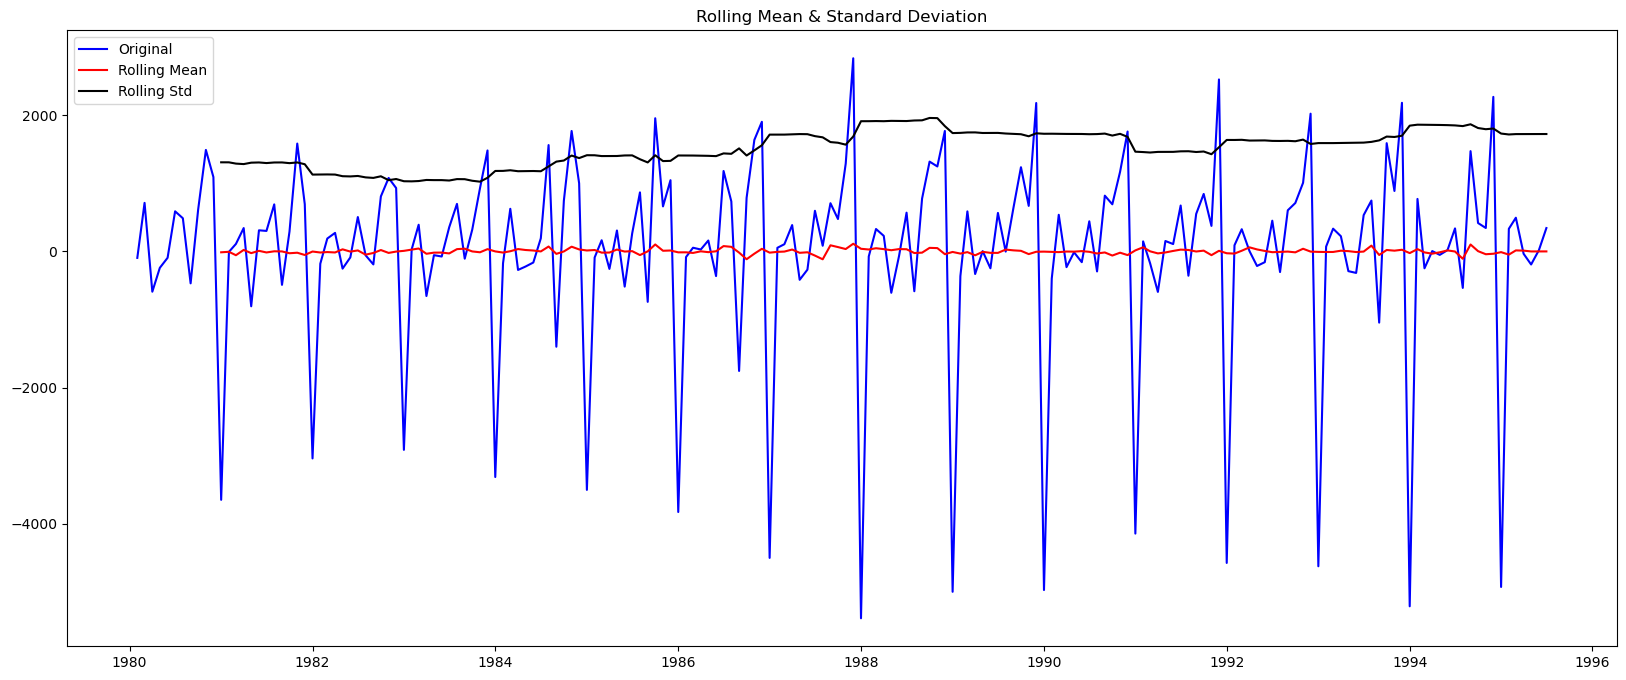

Results of Dickey-Fuller Test:
Test Statistic                 -45.050301
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [346]:
print('Stationarity of original data')
test_stationarity(sparkling_sales)
print('\n Stationarity after first order differencing')
test_stationarity(diff_series)

Observations:
- The given series was originally non- stationary, as evidenced by the Dickey Fuller test, with resulted in a p-value of 0.6
- After performing a first order differencing, stationarity was established. The Dickey fuller test on the differenced series resulted in a p-value of 0.0, which is less than the critical value of 0.05.

## Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other additional models such as regression, naïve forecast models, simple average models, moving average models should also be built on the training data and check the performance on the test data using RMSE.

### Simple Models

#### Linear Regression

In [351]:
train_time=[i+1 for i in range(len(train))]
test_time=[i+133 for i in range(len(test))]
print(train_time)
print(test_time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
[133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [352]:
lr_train_df=train.copy()
lr_test_df=test.copy()
lr_train_df

Sparkling
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047

[132 rows x 1 columns]

In [353]:
lr_train_df['Time']=train_time
lr_test_df['Time']=test_time

In [358]:
lr_model=LinearRegression()
lr_model.fit(lr_train_df[['Time']],lr_train_df['Sparkling'].values)

LinearRegression()

In [360]:
lr_model_predict=lr_model.predict(lr_test_df[['Time']])

lr_test_df['predictions']=lr_model_predict

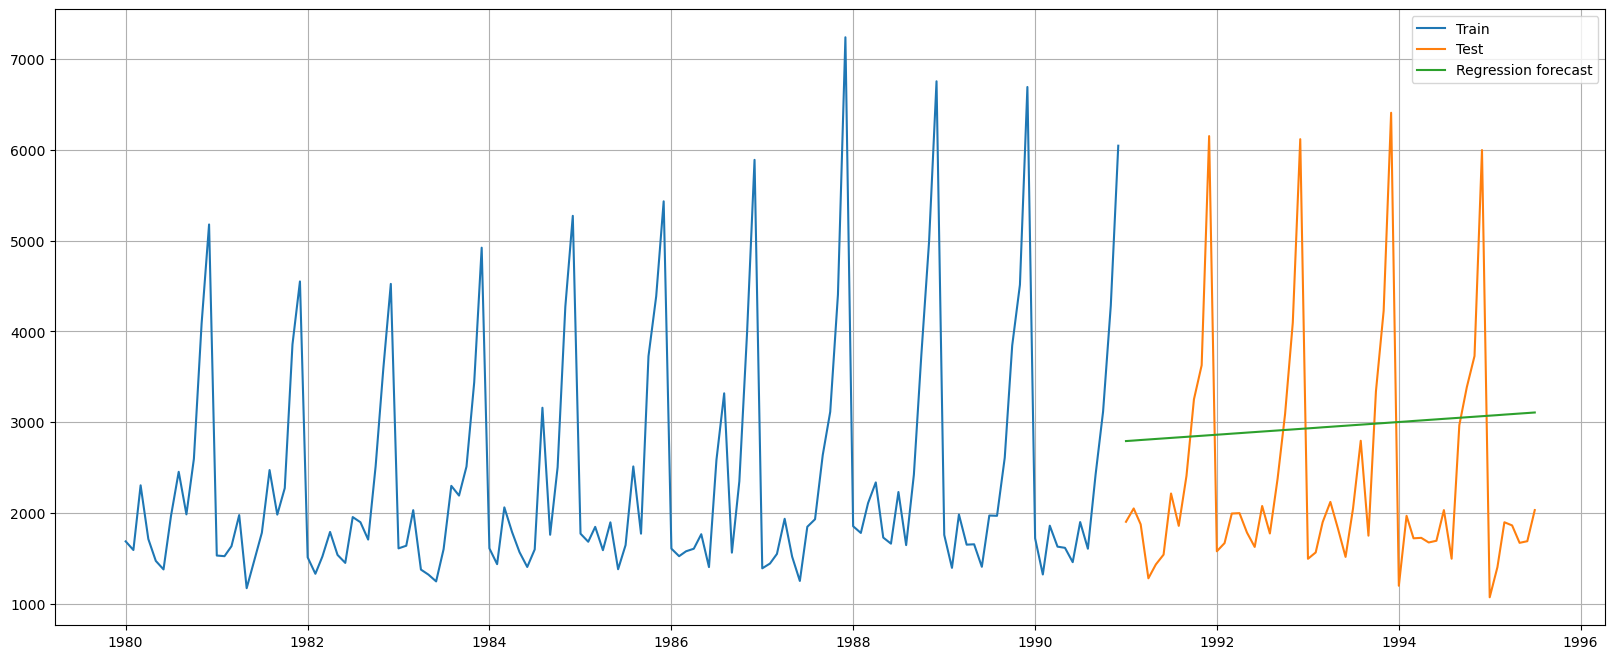

In [361]:
plt.plot(lr_train_df['Sparkling'],label='Train')
plt.plot(lr_test_df['Sparkling'],label='Test')
plt.plot(lr_test_df['predictions'],label='Regression forecast')
plt.legend(loc='best')
plt.grid();

In [405]:
rmse_lr=np.sqrt(mean_squared_error(lr_test_df['Sparkling'],lr_test_df['predictions'])).round(2)
rmse_lr

1389.14

In [412]:
results_df=pd.DataFrame({'Test RMSE': rmse_lr},index =['LinearRegression'])
results_df

Test RMSE
LinearRegression    1389.14

#### Naive Forecast

In [383]:
naive_train=train.copy()
naive_test=test.copy()

In [403]:
naive_test['predictions']=np.asarray(naive_train['Sparkling'])[len(np.asarray(naive_train['Sparkling']))-1]

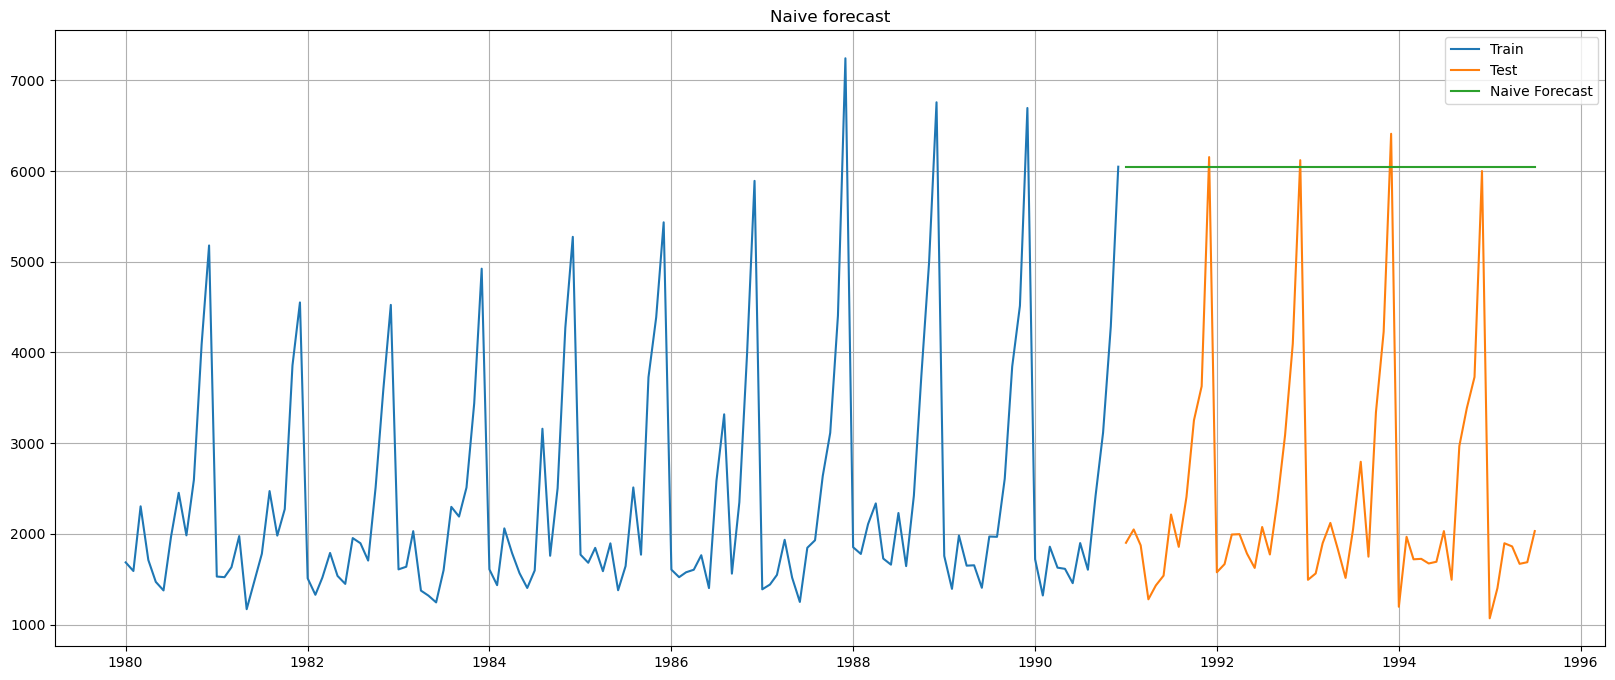

In [404]:
plt.plot(naive_train['Sparkling'],label='Train')
plt.plot(naive_test['Sparkling'],label='Test')
plt.plot(naive_test['predictions'],label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive forecast')
plt.grid();

In [408]:
rmse_naive=np.sqrt(mean_squared_error(naive_test['Sparkling'],naive_test['predictions'])).round(2)
rmse_naive

3864.28

In [413]:
naive_df=pd.DataFrame({'Test RMSE': rmse_naive},index=['NaiveForecast'])
results_df=pd.concat([results_df,naive_df])
results_df

Test RMSE
LinearRegression    1389.14
NaiveForecast       3864.28

#### Simple average Model

In [414]:
sa_train=train.copy()
sa_test=test.copy()

In [416]:
sa_test['predictions']=sa_train['Sparkling'].mean()

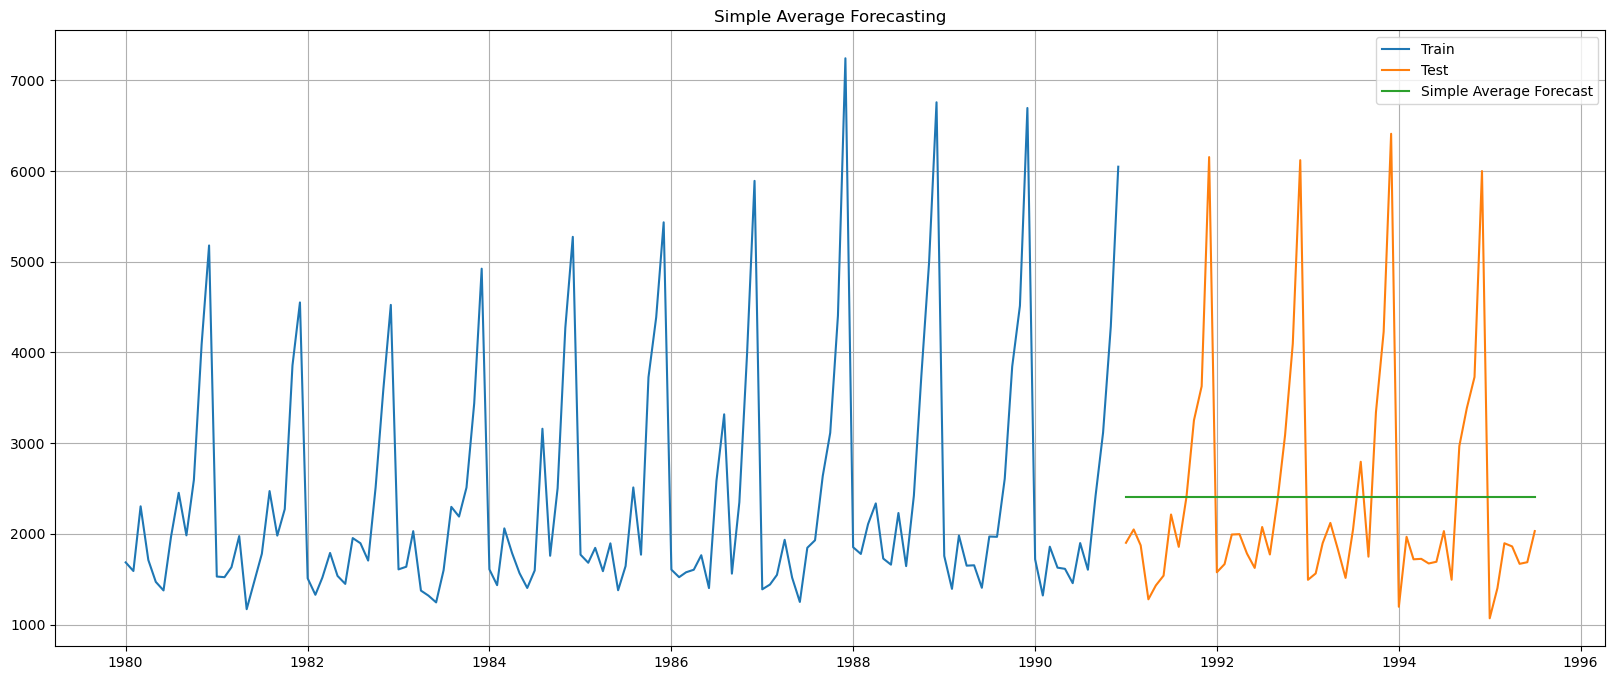

In [419]:
plt.plot(sa_train['Sparkling'],label='Train')
plt.plot(sa_test['Sparkling'],label='Test')
plt.plot(sa_test['predictions'],label='Simple Average Forecast')
plt.title('Simple Average Forecasting')
plt.legend(loc='best')
plt.grid();

In [421]:
rmse_sa=np.sqrt(mean_squared_error(sa_test['Sparkling'],sa_test['predictions'])).round(2)
rmse_sa

1275.08

In [422]:
sa_df=pd.DataFrame({'Test RMSE': rmse_sa},index=['SimpleAvgForecast'])
results_df=pd.concat([results_df,sa_df])
results_df

Test RMSE
LinearRegression     1389.14
NaiveForecast        3864.28
SimpleAvgForecast    1275.08

#### Moving average model

In [428]:
ma_df=spark_df.copy()

In [433]:
ma_df['trail2']=ma_df['Sparkling'].rolling(2).mean().round(2)
ma_df['trail3']=ma_df['Sparkling'].rolling(3).mean().round(2)
ma_df['trail6']=ma_df['Sparkling'].rolling(6).mean().round(2)
ma_df['trail12']=ma_df['Sparkling'].rolling(12).mean().round(2)

In [435]:
ma_train=ma_df[ma_df.index.year<1991]
ma_test=ma_df[ma_df.index.year>=1991]

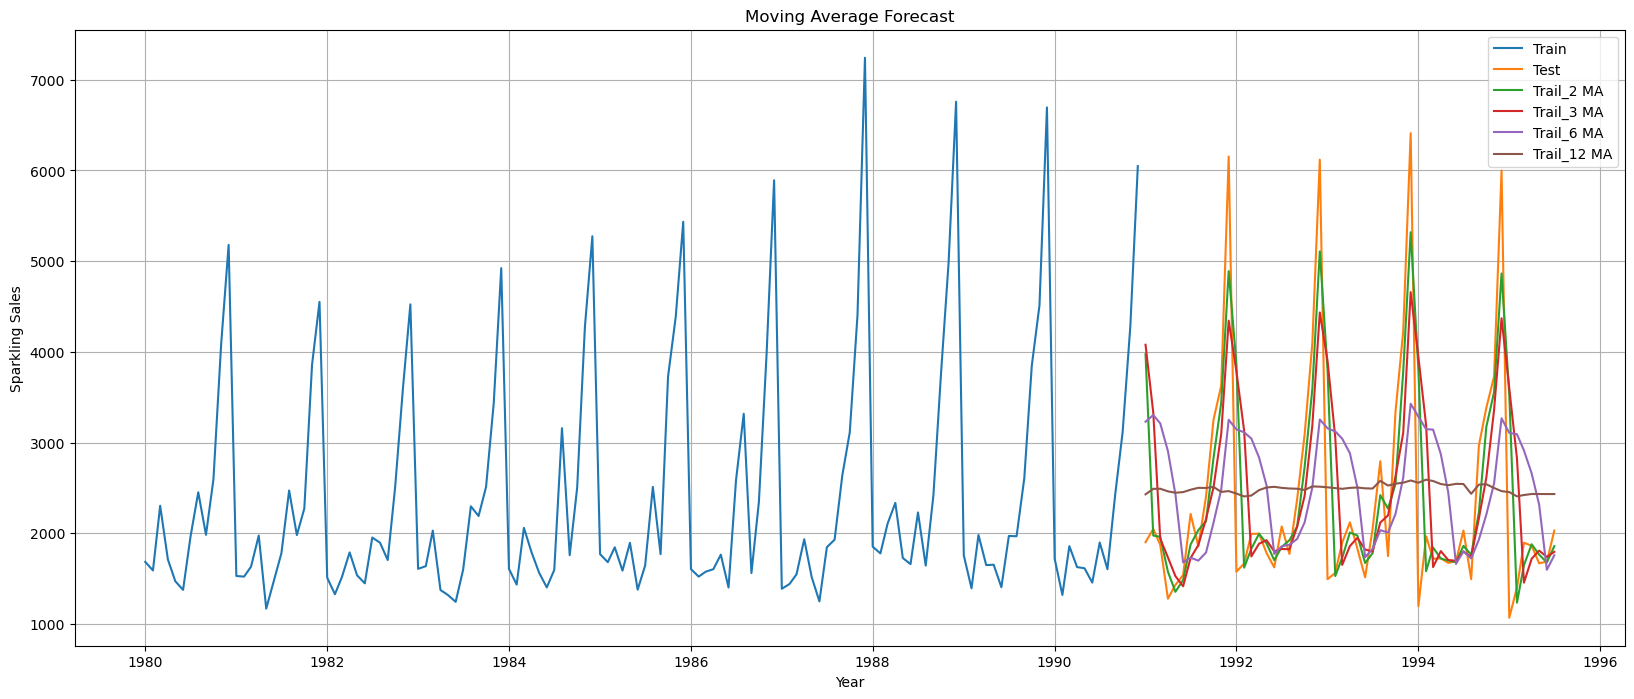

In [445]:
plt.plot(ma_train['Sparkling'],label='Train')
plt.plot(ma_test['Sparkling'],label='Test')
plt.plot(ma_test['trail2'],label='Trail_2 MA')
plt.plot(ma_test['trail3'],label='Trail_3 MA')
plt.plot(ma_test['trail6'],label='Trail_6 MA')
plt.plot(ma_test['trail12'],label='Trail_12 MA')
plt.xlabel('Year')
plt.ylabel('Sparkling Sales')
plt.title('Moving Average Forecast')
plt.legend(loc='best')
plt.grid();

In [439]:
rmse_ma_trail2=np.sqrt(mean_squared_error(ma_test['Sparkling'],ma_test['trail2'])).round(2)
rmse_ma_trail3=np.sqrt(mean_squared_error(ma_test['Sparkling'],ma_test['trail3'])).round(2)
rmse_ma_trail6=np.sqrt(mean_squared_error(ma_test['Sparkling'],ma_test['trail6'])).round(2)
rmse_ma_trail12=np.sqrt(mean_squared_error(ma_test['Sparkling'],ma_test['trail12'])).round(2)

In [441]:
ma_res_df=pd.DataFrame({'Test RMSE':[rmse_ma_trail2,rmse_ma_trail3,rmse_ma_trail6,rmse_ma_trail12]},index=['MA_trail2','MA_trail3','MA_trail6','MA_trail12'])
ma_res_df

Test RMSE
MA_trail2      813.40
MA_trail3     1028.61
MA_trail6     1283.93
MA_trail12    1267.93

In [442]:
results_df=pd.concat([results_df,ma_res_df])
results_df

Test RMSE
LinearRegression     1389.14
NaiveForecast        3864.28
SimpleAvgForecast    1275.08
MA_trail2             813.40
MA_trail3            1028.61
MA_trail6            1283.93
MA_trail12           1267.93

### Exponential smoothing models

#### Simple Exponential smoothing model

In [446]:
ses_train=train.copy()
ses_test=test.copy()

In [447]:
ses_model=SimpleExpSmoothing(ses_train['Sparkling']).fit(optimized=True)

In [448]:
ses_model.params

{'smoothing_level': 0.03953488372093023,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [451]:
ses_test['predictions']=ses_model.forecast(steps=len(ses_test))
ses_test

Sparkling  predictions
1991-01-01       1902  2676.676366
1991-02-01       2049  2676.676366
1991-03-01       1874  2676.676366
1991-04-01       1279  2676.676366
1991-05-01       1432  2676.676366
1991-06-01       1540  2676.676366
1991-07-01       2214  2676.676366
1991-08-01       1857  2676.676366
1991-09-01       2408  2676.676366
1991-10-01       3252  2676.676366
1991-11-01       3627  2676.676366
1991-12-01       6153  2676.676366
1992-01-01       1577  2676.676366
1992-02-01       1667  2676.676366
1992-03-01       1993  2676.676366
1992-04-01       1997  2676.676366
1992-05-01       1783  2676.676366
1992-06-01       1625  2676.676366
1992-07-01       2076  2676.676366
1992-08-01       1773  2676.676366
1992-09-01       2377  2676.676366
1992-10-01       3088  2676.676366
1992-11-01       4096  2676.676366
1992-12-01       6119  2676.676366
1993-01-01       1494  2676.676366
1993-02-01       1564  2676.676366
1993-03-01       1898  2676.676366
1993-04-01       2121  2676.676366
1993-05-01       1831  2676.676366
1993-06-01       1515  2676.676366
1993-07-01       2048  2676.676366
1993-08-01       2795  2676.676366
1993-09-01       1749  2676.676366
1993-10-01       3339  2676.676366
1993-11-01       4227  2676.676366
1993-12-01       6410  2676.676366
1994-01-01       1197  2676.676366
1994-02-01       1968  2676.676366
1994-03-01       1720  2676.676366
1994-04-01       1725  2676.676366
1994-05-01       1674  2676.676366
1994-06-01       1693  2676.676366
1994-07-01       2031  2676.676366
1994-08-01       1495  2676.676366
1994-09-01       2968  2676.676366
1994-10-01       3385  2676.676366
1994-11-01       3729  2676.676366
1994-12-01       5999  2676.676366
1995-01-01       1070  2676.676366
1995-02-01       1402  2676.676366
1995-03-01       1897  2676.676366
1995-04-01       1862  2676.676366
1995-05-01       1670  2676.676366
1995-06-01       1688  2676.676366
1995-07-01       2031  2676.676366

In [454]:
rmse_ses=np.sqrt(mean_squared_error(ses_test['Sparkling'],ses_test['predictions'])).round(2)
rmse_ses

1304.93

In [455]:
ses_df=pd.DataFrame({'Test RMSE': rmse_ses},index=['SimpleExpSmoothing'])
ses_df

Test RMSE
SimpleExpSmoothing    1304.93

In [456]:
results_df=pd.concat([results_df,ses_df])
results_df

Test RMSE
LinearRegression      1389.14
NaiveForecast         3864.28
SimpleAvgForecast     1275.08
MA_trail2              813.40
MA_trail3             1028.61
MA_trail6             1283.93
MA_trail12            1267.93
SimpleExpSmoothing    1304.93

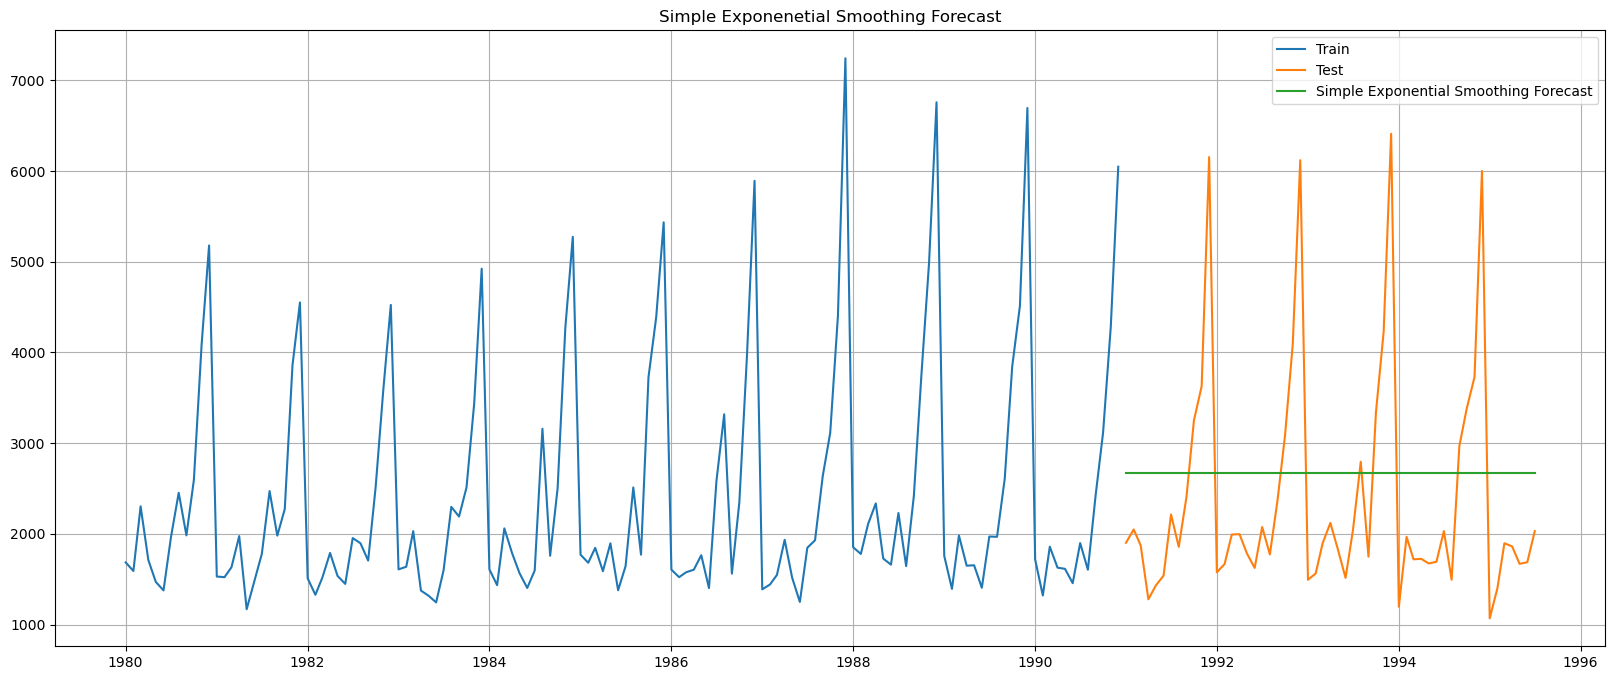

In [457]:
plt.plot(ses_train['Sparkling'],label='Train')
plt.plot(ses_test['Sparkling'],label='Test')
plt.plot(ses_test['predictions'],label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponenetial Smoothing Forecast')
plt.legend(loc='best')
plt.grid();

In [469]:
ses_alpha_df=pd.DataFrame({'Alpha':[],'Rmse_test':[]})

In [470]:
for i in np.arange(0.01,1,0.10):
    ses_alpha=SimpleExpSmoothing(ses_train['Sparkling']).fit(smoothing_level=i,optimized=False)
    ses_test['predict',i]=ses_alpha.forecast(steps=len(test))
    rmse_alpha=np.sqrt(mean_squared_error(ses_test['Sparkling'],ses_test['predict',i]))
    ses_alpha_df=ses_alpha_df.append({'Alpha':i,'Rmse_test':rmse_alpha},ignore_index=True)

In [471]:
ses_alpha_df

Alpha    Rmse_test
0   0.01  1281.032699
1   0.11  1390.502810
2   0.21  1625.101684
3   0.31  1972.843244
4   0.41  2348.917539
5   0.51  2699.604628
6   0.61  3008.106488
7   0.71  3274.888746
8   0.81  3505.393351
9   0.91  3705.611326

In [472]:
ses_alpha_model=SimpleExpSmoothing(ses_train['Sparkling']).fit(smoothing_level=0.01,optimized=False)

In [473]:
ses_test['alpha_predict']=ses_alpha_model.forecast(steps=len(ses_test))

In [474]:
rmse_ses_alpha_model=np.sqrt(mean_squared_error(ses_test['Sparkling'],ses_test['alpha_predict'])).round(2)
rmse_ses_alpha_model

1281.03

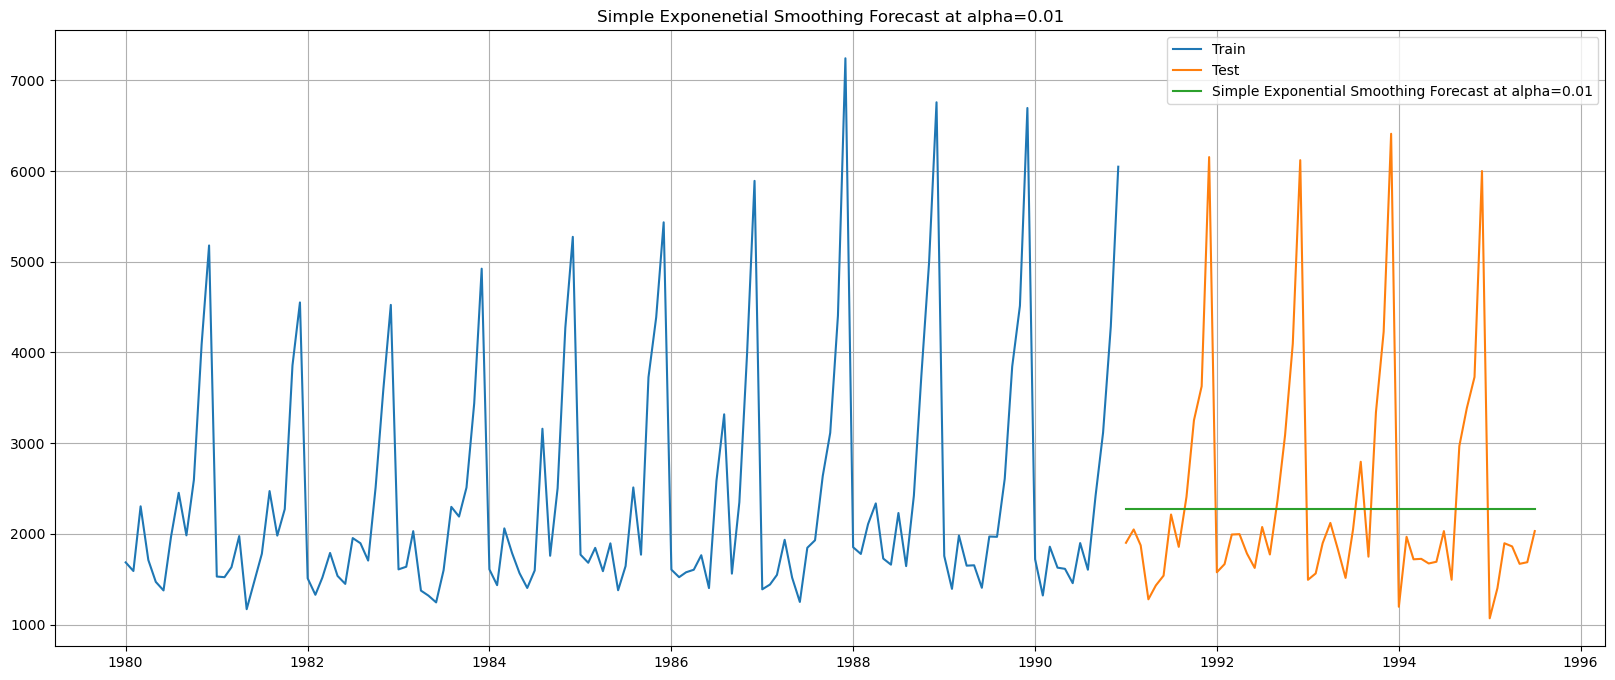

In [485]:
plt.plot(ses_train['Sparkling'],label='Train')
plt.plot(ses_test['Sparkling'],label='Test')
plt.plot(ses_test['alpha_predict'],label='Simple Exponential Smoothing Forecast at alpha=0.01')
plt.title('Simple Exponenetial Smoothing Forecast at alpha=0.01')
plt.legend(loc='best')
plt.grid();

In [476]:
ses_alpha_model_results_df=pd.DataFrame({'Test RMSE':rmse_ses_alpha_model},index=['SimpExpSmoothingAlpha0.01'])
ses_alpha_model_results_df

Test RMSE
SimpExpSmoothingAlpha0.01    1281.03

In [477]:
results_df=pd.concat([results_df,ses_alpha_model_results_df])

In [478]:
results_df

Test RMSE
LinearRegression             1389.14
NaiveForecast                3864.28
SimpleAvgForecast            1275.08
MA_trail2                     813.40
MA_trail3                    1028.61
MA_trail6                    1283.93
MA_trail12                   1267.93
SimpleExpSmoothing           1304.93
SimpExpSmoothingAlpha0.01    1281.03

#### Holt model

In [479]:
holt_train=train.copy()
holt_test=test.copy()

In [480]:
holt_model=Holt(holt_train['Sparkling']).fit(optimized=True)

In [481]:
holt_model.params

{'smoothing_level': 0.6885714285714285,
 'smoothing_trend': 9.999999999999999e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': -95.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [482]:
holt_test['predictions']=holt_model.forecast(steps=len(holt_test))

In [483]:
rmse_holt=np.sqrt(mean_squared_error(holt_test['Sparkling'],holt_test['predictions'])).round(2)
rmse_holt

2007.24

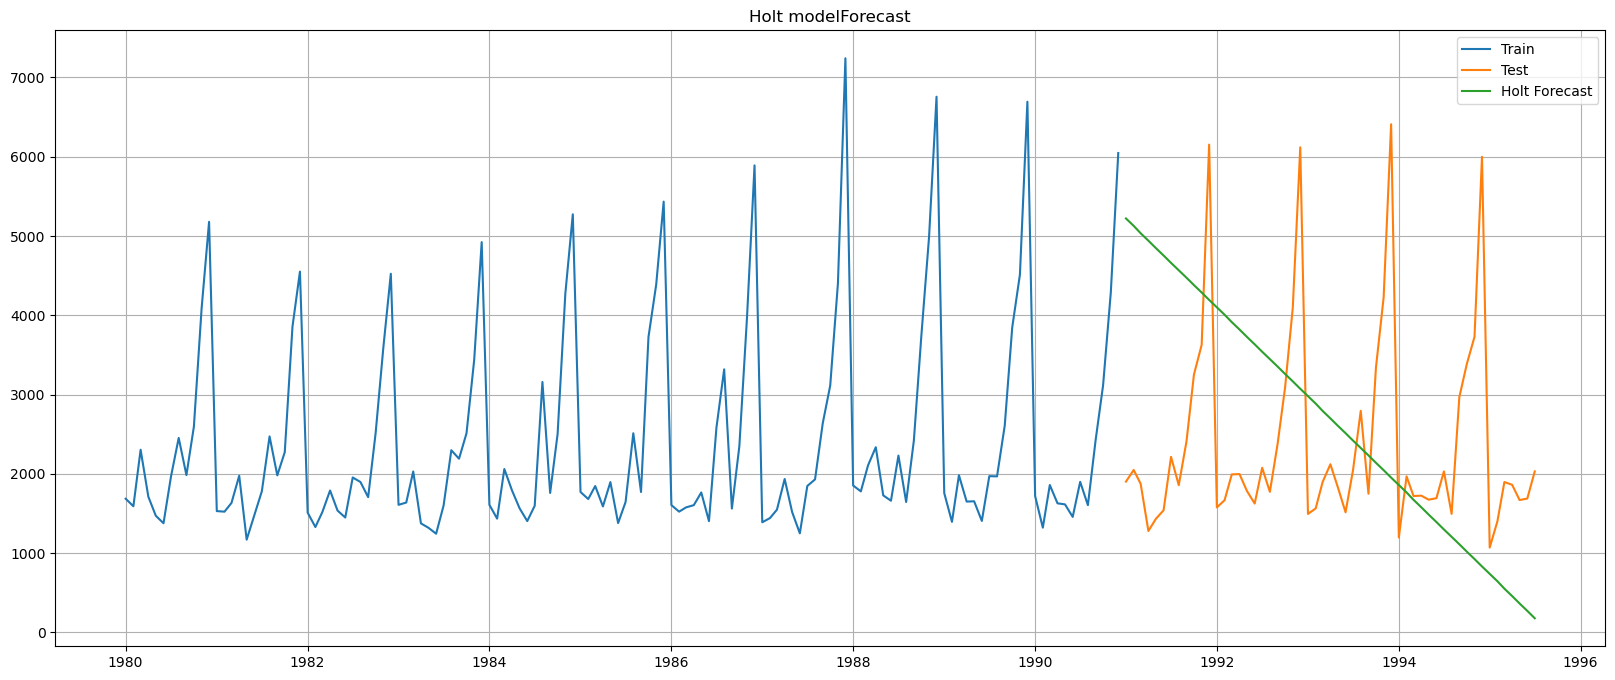

In [484]:
plt.plot(holt_train['Sparkling'],label='Train')
plt.plot(holt_test['Sparkling'],label='Test')
plt.plot(holt_test['predictions'],label='Holt Forecast')
plt.title('Holt modelForecast')
plt.legend(loc='best')
plt.grid();

In [486]:
holt_autofit_df=pd.DataFrame({'Test RMSE':rmse_holt},index=['HoltAutofit'])
holt_autofit_df

Test RMSE
HoltAutofit    2007.24

In [487]:
results_df=pd.concat([results_df,holt_autofit_df])
results_df

Test RMSE
LinearRegression             1389.14
NaiveForecast                3864.28
SimpleAvgForecast            1275.08
MA_trail2                     813.40
MA_trail3                    1028.61
MA_trail6                    1283.93
MA_trail12                   1267.93
SimpleExpSmoothing           1304.93
SimpExpSmoothingAlpha0.01    1281.03
HoltAutofit                  2007.24

In [491]:
holt_alpha_df=pd.DataFrame({'Alpha':[],'Beta':[],'Rmse':[]})

In [497]:
for i in np.arange(0,1,0.1):
    for j in np.arange(0,1,0.1):
        holt_alpha=Holt(holt_train['Sparkling']).fit(smoothing_level=i,smoothing_trend=j,optimized=False)
        holt_test['predict',i]=holt_alpha.forecast(steps=len(holt_test))
        rmse_holt_alpha=np.sqrt(mean_squared_error(holt_test['Sparkling'],holt_test['predict',i]))
        holt_alpha_df=holt_alpha_df.append({'Alpha':i,'Beta':j,'Rmse':rmse_holt_alpha},ignore_index=True)
holt_alpha_df.sort_values(by='Rmse',ascending=True)

Alpha  Beta          Rmse
111    0.1   0.1   1778.564670
11     0.1   0.1   1778.564670
60     0.6   0.0   2004.479267
160    0.6   0.0   2004.479267
170    0.7   0.0   2024.922482
..     ...   ...           ...
179    0.7   0.9  55381.643382
189    0.8   0.9  56066.164083
89     0.8   0.9  56066.164083
99     0.9   0.9  56958.249632
199    0.9   0.9  56958.249632

[200 rows x 3 columns]

In [498]:
holt_alpha_model=Holt(holt_train['Sparkling']).fit(smoothing_level=0.1,smoothing_trend=0.1,optimized=False)

In [499]:
holt_test['alpha predict']=holt_alpha_model.forecast(steps=len(holt_test))

In [500]:
rmse_holt_alpha_model=np.sqrt(mean_squared_error(holt_test['Sparkling'],holt_test['alpha predict'])).round(2)
rmse_holt_alpha_model

1778.56

In [501]:
holt_alpha_model.params

{'smoothing_level': 0.1,
 'smoothing_trend': 0.1,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': -95.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

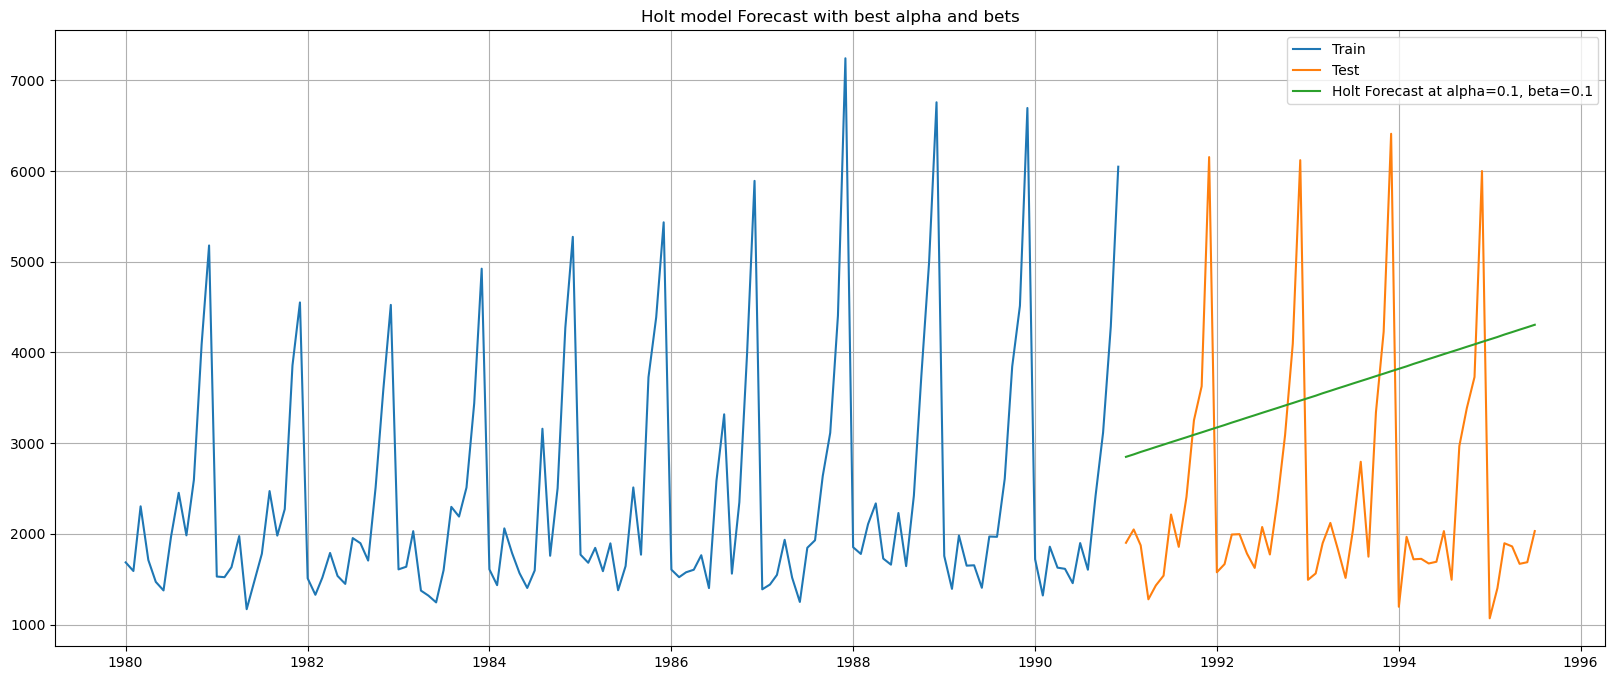

In [502]:
plt.plot(holt_train['Sparkling'],label='Train')
plt.plot(holt_test['Sparkling'],label='Test')
plt.plot(holt_test['alpha predict'],label='Holt Forecast at alpha=0.1, beta=0.1')
plt.title('Holt model Forecast with best alpha and bets')
plt.legend(loc='best')
plt.grid();

In [503]:
holt_alpha_model_results_df=pd.DataFrame({'Test RMSE':rmse_holt_alpha_model},index=['HoltBestAlphaBeta'])
holt_alpha_model_results_df

Test RMSE
HoltBestAlphaBeta    1778.56

In [504]:
results_df=pd.concat([results_df,holt_alpha_model_results_df])
results_df

Test RMSE
LinearRegression             1389.14
NaiveForecast                3864.28
SimpleAvgForecast            1275.08
MA_trail2                     813.40
MA_trail3                    1028.61
MA_trail6                    1283.93
MA_trail12                   1267.93
SimpleExpSmoothing           1304.93
SimpExpSmoothingAlpha0.01    1281.03
HoltAutofit                  2007.24
HoltBestAlphaBeta            1778.56

#### Holt-winters model

In [530]:
hw_train=train.copy()
hw_test=test.copy()

In [532]:
hw_model=ExponentialSmoothing(hw_train['Sparkling'],trend='additive',seasonal='additive').fit(optimized=True)

In [533]:
hw_model.params

{'smoothing_level': 0.11127227248079453,
 'smoothing_trend': 0.012360804305088534,
 'smoothing_seasonal': 0.46071766688111543,
 'damping_trend': nan,
 'initial_level': 2356.577980956387,
 'initial_trend': -0.10243675533021725,
 'initial_seasons': array([-636.23319334, -722.9832009 , -398.64410813, -473.43045416,
        -808.42473284, -815.34991402, -384.23065038,   72.99484403,
        -237.44226045,  272.32608272, 1541.37737052, 2590.07692296]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [534]:
hw_test['predictions']=hw_model.forecast(steps=len(hw_test))

In [535]:
rmse_hw=np.sqrt(mean_squared_error(hw_test['Sparkling'],hw_test['predictions'])).round(2)
rmse_hw

378.95

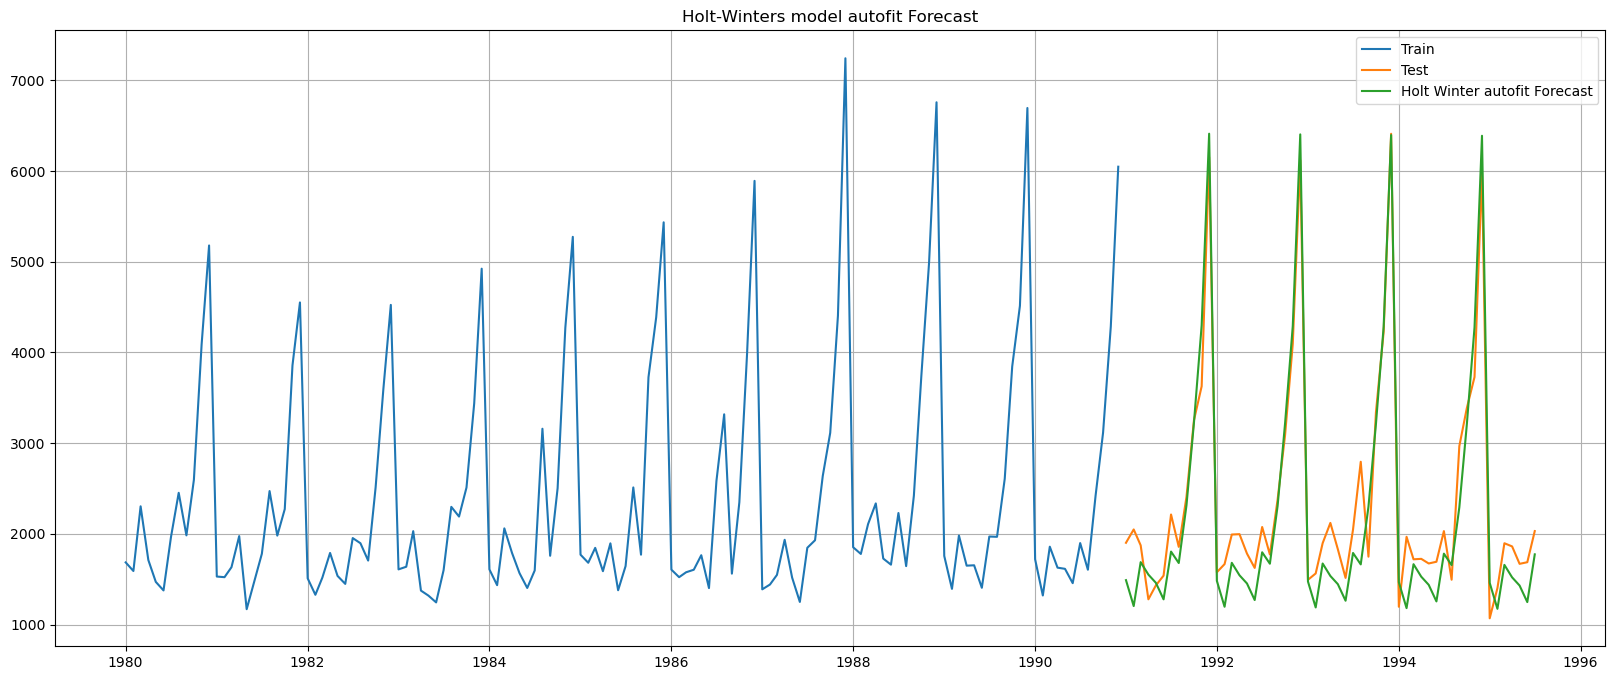

In [536]:
plt.plot(hw_train['Sparkling'],label='Train')
plt.plot(hw_test['Sparkling'],label='Test')
plt.plot(hw_test['predictions'],label='Holt Winter autofit Forecast')
plt.title('Holt-Winters model autofit Forecast')
plt.legend(loc='best')
plt.grid();

In [537]:
hw_df=pd.DataFrame({'Test RMSE':rmse_hw},index=['HoltWintersAutofit'])
hw_df

Test RMSE
HoltWintersAutofit     378.95

In [539]:
results_df=pd.concat([results_df,hw_df])
results_df

Test RMSE
LinearRegression             1389.14
NaiveForecast                3864.28
SimpleAvgForecast            1275.08
MA_trail2                     813.40
MA_trail3                    1028.61
MA_trail6                    1283.93
MA_trail12                   1267.93
SimpleExpSmoothing           1304.93
SimpExpSmoothingAlpha0.01    1281.03
HoltAutofit                  2007.24
HoltBestAlphaBeta            1778.56
HoltWintersAutofit            378.95

In [540]:
hw_alpha_df=pd.DataFrame({'Alpha':[],'Beta':[],'Gamma':[],'RMSE Test':[]})

In [545]:
for i in np.arange(0.01,0.1,0.01):
    for j in np.arange(0,1,0.1):
        for k in np.arange(0.1,1,0.1):
            hw_alpha=ExponentialSmoothing(hw_train['Sparkling'],seasonal='additive').fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k)
            hw_test['predict',i,j,k]=hw_alpha.forecast(steps=len(hw_test))
            rmse_hw_alpha=np.sqrt(mean_squared_error(hw_test['Sparkling'],hw_test['predict',i,j,k]))
            hw_alpha_df=hw_alpha_df.append({'Alpha':i,'Beta':j,'Gamma':k,'RMSE Test':rmse_hw_alpha},ignore_index=True)
hw_alpha_df.sort_values(by='RMSE Test')

Alpha  Beta  Gamma   RMSE Test
1414   0.07   0.7    0.2  303.181892
541    0.07   0.0    0.2  303.181892
1369   0.07   0.2    0.2  303.181892
1387   0.07   0.4    0.2  303.181892
550    0.07   0.1    0.2  303.181892
...     ...   ...    ...         ...
1565   0.09   0.3    0.9  409.506808
1574   0.09   0.4    0.9  409.506808
1583   0.09   0.5    0.9  409.506808
1601   0.09   0.7    0.9  409.506808
1619   0.09   0.9    0.9  409.506808

[1620 rows x 4 columns]

Observations:
- Here we can see that the best results are obtained with alpha=0.07 and gamma=0.2, irrespective of the beta value
- We noticed that the given series has no trend, and hence the results obtained are consistent with the assumptions

In [547]:
hw_alpha_model=ExponentialSmoothing(hw_train['Sparkling'],seasonal='additive').fit(smoothing_level=0.07,smoothing_seasonal=0.2,optimized=False)

In [548]:
hw_alpha_model.params

{'smoothing_level': 0.07,
 'smoothing_trend': None,
 'smoothing_seasonal': 0.2,
 'damping_trend': nan,
 'initial_level': 2356.541666666665,
 'initial_trend': nan,
 'initial_seasons': array([-636.18663194, -722.94704861, -398.70746528, -473.40538194,
        -808.38454861, -815.31163194, -384.22829861,   72.94878472,
        -237.39496528,  272.33420139, 1541.28211806, 2590.00086806]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [549]:
hw_test['alpha predictions']=hw_alpha_model.forecast(steps=len(hw_test))

In [550]:
rmse_hw_alpha_model=np.sqrt(mean_squared_error(hw_test['Sparkling'],hw_test['alpha predictions'])).round(2)
rmse_hw_alpha_model

302.41

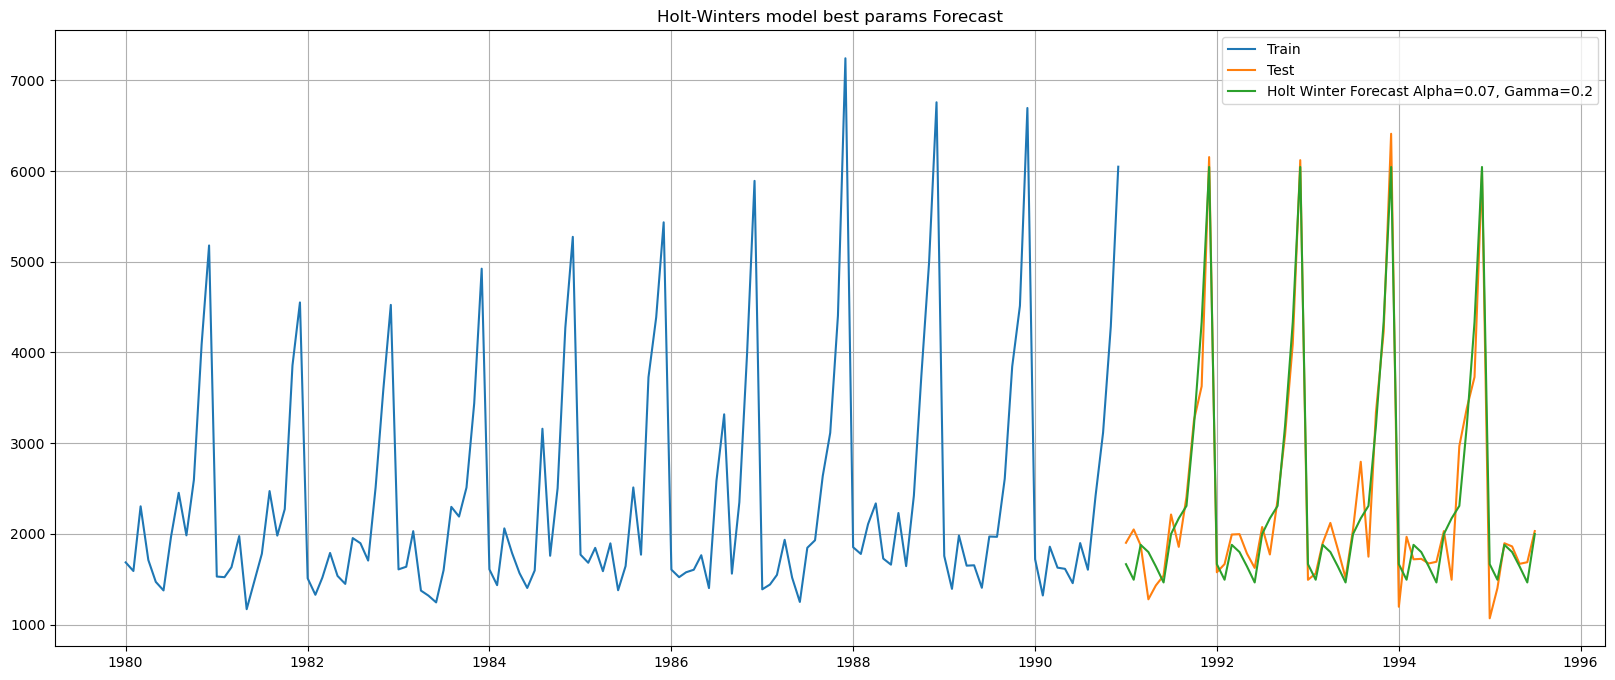

In [551]:
plt.plot(hw_train['Sparkling'],label='Train')
plt.plot(hw_test['Sparkling'],label='Test')
plt.plot(hw_test['alpha predictions'],label='Holt Winter Forecast Alpha=0.07, Gamma=0.2')
plt.title('Holt-Winters model best params Forecast')
plt.legend(loc='best')
plt.grid();

In [552]:
hw_alpha_results_df=pd.DataFrame({'Test RMSE':rmse_hw_alpha_model},index=['HoltWintersalpha0.07gamma0.2'])
hw_alpha_results_df

Test RMSE
HoltWintersalpha0.07gamma0.2     302.41

In [553]:
results_df=pd.concat([results_df,hw_alpha_results_df])
results_df

Test RMSE
LinearRegression                1389.14
NaiveForecast                   3864.28
SimpleAvgForecast               1275.08
MA_trail2                        813.40
MA_trail3                       1028.61
MA_trail6                       1283.93
MA_trail12                      1267.93
SimpleExpSmoothing              1304.93
SimpExpSmoothingAlpha0.01       1281.03
HoltAutofit                     2007.24
HoltBestAlphaBeta               1778.56
HoltWintersAutofit               378.95
HoltWintersalpha0.07gamma0.2     302.41

## Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [586]:
import itertools
p = q = range(0, 3)
d= range(0,2) #Determined during stationarity test
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0],  x[1], x[2],12) for x in list(itertools.product(p,d,q))]
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

### ARIMA

In [564]:
arima_aic_df=pd.DataFrame(columns=['param','AIC'])

In [565]:
arima_train=train.copy()
arima_test=test.copy()

In [569]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    arima_model = ARIMA(arima_train['Sparkling'], order=param)
    results_arima = arima_model.fit()
    print('ARIMA{} - AIC:{}'.format(param, results_arima.aic))
    arima_aic_df = arima_aic_df.append({'param':param, 'AIC': results_arima.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:2271.2058190597454
ARIMA(0, 0, 1) - AIC:2245.312135662967
ARIMA(0, 0, 2) - AIC:2245.3471843316183
ARIMA(0, 1, 0) - AIC:2267.6630357855465
ARIMA(0, 1, 1) - AIC:2263.060015591336
ARIMA(0, 1, 2) - AIC:2234.408323131676
ARIMA(1, 0, 0) - AIC:2247.3588287243665
ARIMA(1, 0, 1) - AIC:2246.0053997283453
ARIMA(1, 0, 2) - AIC:2246.93570045236
ARIMA(1, 1, 0) - AIC:2266.6085393190087
ARIMA(1, 1, 1) - AIC:2235.755094673378
ARIMA(1, 1, 2) - AIC:2234.5272004508324
ARIMA(2, 0, 0) - AIC:2244.8117819003037
ARIMA(2, 0, 1) - AIC:2236.5908602019135
ARIMA(2, 0, 2) - AIC:2248.2772806942694
ARIMA(2, 1, 0) - AIC:2260.365743968086
ARIMA(2, 1, 1) - AIC:2233.7776263084434
ARIMA(2, 1, 2) - AIC:2213.5092122972337


In [570]:
arima_aic_df.sort_values(by='AIC')

param          AIC
17  (2, 1, 2)  2213.509212
16  (2, 1, 1)  2233.777626
5   (0, 1, 2)  2234.408323
11  (1, 1, 2)  2234.527200
10  (1, 1, 1)  2235.755095
13  (2, 0, 1)  2236.590860
12  (2, 0, 0)  2244.811782
1   (0, 0, 1)  2245.312136
2   (0, 0, 2)  2245.347184
7   (1, 0, 1)  2246.005400
8   (1, 0, 2)  2246.935700
6   (1, 0, 0)  2247.358829
14  (2, 0, 2)  2248.277281
15  (2, 1, 0)  2260.365744
4   (0, 1, 1)  2263.060016
9   (1, 1, 0)  2266.608539
3   (0, 1, 0)  2267.663036
0   (0, 0, 0)  2271.205819

In [573]:
arima_best_model=ARIMA(arima_train['Sparkling'],order=(2,1,2)).fit()
print(arima_best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1101.755
Date:                Fri, 10 Nov 2023   AIC                           2213.509
Time:                        22:09:17   BIC                           2227.885
Sample:                    01-01-1980   HQIC                          2219.351
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.046     28.781      0.000       1.223       1.401
ar.L2         -0.5593      0.072     -7.741      0.000      -0.701      -0.418
ma.L1         -1.9917      0.109    -18.218      0.0

In [574]:
arima_test['predictions']=arima_best_model.forecast(steps=len(arima_test))

In [575]:
rmse_arima=np.sqrt(mean_squared_error(arima_test['Sparkling'],arima_test['predictions'])).round(2)
rmse_arima

1299.98

In [576]:
arima_results=pd.DataFrame({'Test RMSE': rmse_arima},index=['ARIMA'])
arima_results

Test RMSE
ARIMA    1299.98

In [577]:
results_df=pd.concat([results_df,arima_results])
results_df

Test RMSE
LinearRegression                1389.14
NaiveForecast                   3864.28
SimpleAvgForecast               1275.08
MA_trail2                        813.40
MA_trail3                       1028.61
MA_trail6                       1283.93
MA_trail12                      1267.93
SimpleExpSmoothing              1304.93
SimpExpSmoothingAlpha0.01       1281.03
HoltAutofit                     2007.24
HoltBestAlphaBeta               1778.56
HoltWintersAutofit               378.95
HoltWintersalpha0.07gamma0.2     302.41
ARIMA                           1299.98

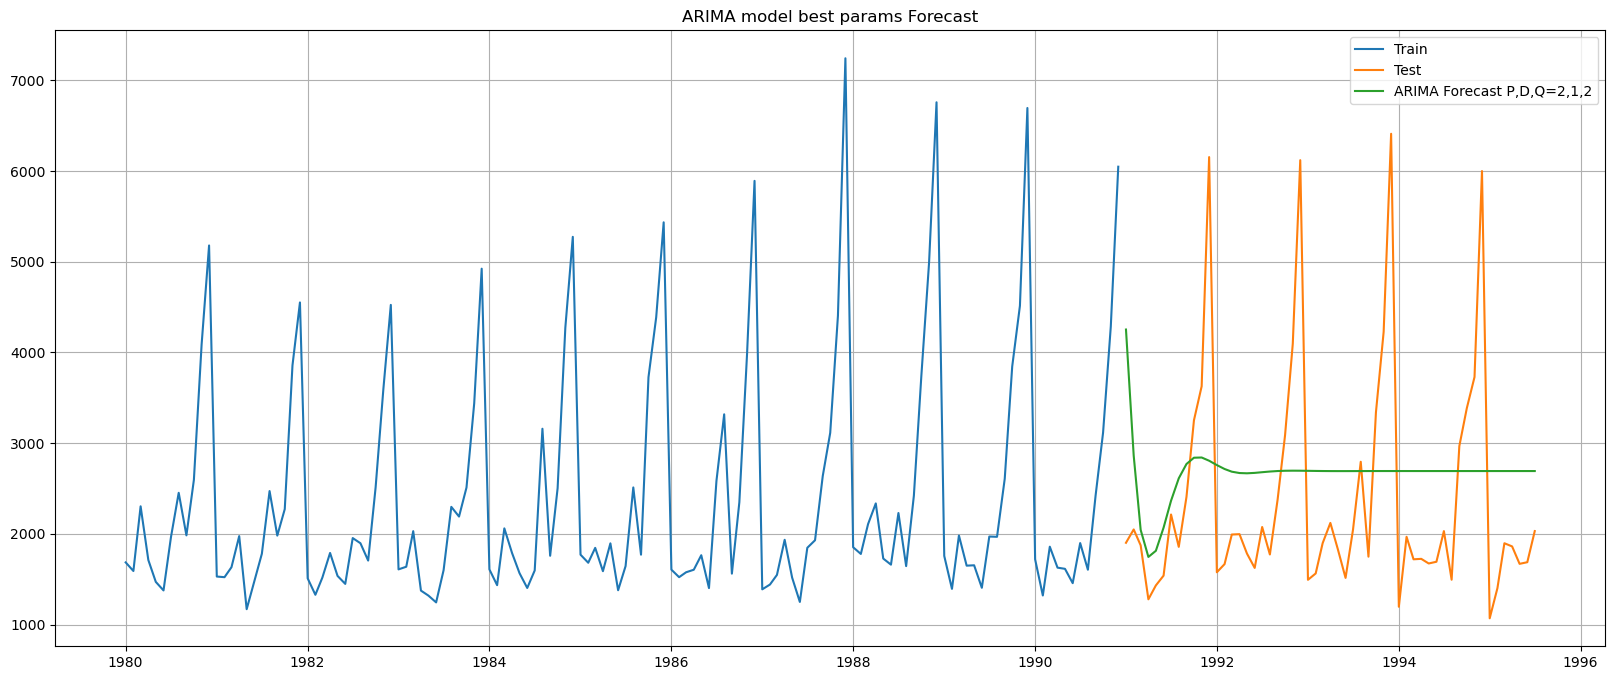

In [578]:
plt.plot(arima_train['Sparkling'],label='Train')
plt.plot(arima_test['Sparkling'],label='Test')
plt.plot(arima_test['predictions'],label='ARIMA Forecast P,D,Q=2,1,2')
plt.title('ARIMA model best params Forecast')
plt.legend(loc='best')
plt.grid();

### SARIMA

In [579]:
sarima_train=train.copy()
sarima_test=test.copy()

In [580]:
sarima_df = pd.DataFrame(columns=['param','seasonal', 'AIC'])
sarima_df

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [587]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        sarima_model = sm.tsa.statespace.SARIMAX(sarima_train['Sparkling'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, sarima_model.aic))
        sarima_df = sarima_df.append({'param':param,'seasonal':param_seasonal ,'AIC': sarima_model.aic}, ignore_index=True)
sarima_df       

SARIMA(0, 0, 0)x(0, 0, 0, 12)7 - AIC:2447.5387828489993
SARIMA(0, 0, 0)x(0, 0, 1, 12)7 - AIC:2094.785599210927
SARIMA(0, 0, 0)x(0, 0, 2, 12)7 - AIC:1815.8304642861422
SARIMA(0, 0, 0)x(0, 1, 0, 12)7 - AIC:1786.4850411919438
SARIMA(0, 0, 0)x(0, 1, 1, 12)7 - AIC:1596.2586002542682
SARIMA(0, 0, 0)x(0, 1, 2, 12)7 - AIC:1428.1357423138356
SARIMA(0, 0, 0)x(1, 0, 0, 12)7 - AIC:1802.3841958898233
SARIMA(0, 0, 0)x(1, 0, 1, 12)7 - AIC:1765.9902957951565
SARIMA(0, 0, 0)x(1, 0, 2, 12)7 - AIC:1602.6508528654424
SARIMA(0, 0, 0)x(1, 1, 0, 12)7 - AIC:1615.0445907515473
SARIMA(0, 0, 0)x(1, 1, 1, 12)7 - AIC:1598.2582087357487
SARIMA(0, 0, 0)x(1, 1, 2, 12)7 - AIC:1429.736216740961
SARIMA(0, 0, 0)x(2, 0, 0, 12)7 - AIC:1616.3804986882144
SARIMA(0, 0, 0)x(2, 0, 1, 12)7 - AIC:1612.0535874420873
SARIMA(0, 0, 0)x(2, 0, 2, 12)7 - AIC:1596.086188652775
SARIMA(0, 0, 0)x(2, 1, 0, 12)7 - AIC:1441.2182003596358
SARIMA(0, 0, 0)x(2, 1, 1, 12)7 - AIC:1443.0752316172066
SARIMA(0, 0, 0)x(2, 1, 2, 12)7 - AIC:1429.132845275

SARIMA(1, 0, 2)x(0, 1, 0, 12)7 - AIC:1751.9004726127548
SARIMA(1, 0, 2)x(0, 1, 1, 12)7 - AIC:1567.6427400307043
SARIMA(1, 0, 2)x(0, 1, 2, 12)7 - AIC:1397.2393347347904
SARIMA(1, 0, 2)x(1, 0, 0, 12)7 - AIC:1782.902753530462
SARIMA(1, 0, 2)x(1, 0, 1, 12)7 - AIC:1738.56901244731
SARIMA(1, 0, 2)x(1, 0, 2, 12)7 - AIC:1569.4135371092755
SARIMA(1, 0, 2)x(1, 1, 0, 12)7 - AIC:1597.9697722804594
SARIMA(1, 0, 2)x(1, 1, 1, 12)7 - AIC:1569.5436823208297
SARIMA(1, 0, 2)x(1, 1, 2, 12)7 - AIC:1399.0019069811851
SARIMA(1, 0, 2)x(2, 0, 0, 12)7 - AIC:1600.9410069307985
SARIMA(1, 0, 2)x(2, 0, 1, 12)7 - AIC:1604.7014160014712
SARIMA(1, 0, 2)x(2, 0, 2, 12)7 - AIC:1618.2807809532387
SARIMA(1, 0, 2)x(2, 1, 0, 12)7 - AIC:1425.2654041479268
SARIMA(1, 0, 2)x(2, 1, 1, 12)7 - AIC:1427.1397115569662
SARIMA(1, 0, 2)x(2, 1, 2, 12)7 - AIC:1400.0862083071943
SARIMA(1, 1, 0)x(0, 0, 0, 12)7 - AIC:2250.3181267386713
SARIMA(1, 1, 0)x(0, 0, 1, 12)7 - AIC:1954.3938339903916
SARIMA(1, 1, 0)x(0, 0, 2, 12)7 - AIC:1721.268847635

SARIMA(2, 1, 1)x(1, 0, 0, 12)7 - AIC:1792.8234290832254
SARIMA(2, 1, 1)x(1, 0, 1, 12)7 - AIC:1740.0911274627342
SARIMA(2, 1, 1)x(1, 0, 2, 12)7 - AIC:1581.6113840610842
SARIMA(2, 1, 1)x(1, 1, 0, 12)7 - AIC:1574.372406725534
SARIMA(2, 1, 1)x(1, 1, 1, 12)7 - AIC:1571.8577388006777
SARIMA(2, 1, 1)x(1, 1, 2, 12)7 - AIC:1401.9104199707735
SARIMA(2, 1, 1)x(2, 0, 0, 12)7 - AIC:1577.1235060897175
SARIMA(2, 1, 1)x(2, 0, 1, 12)7 - AIC:1573.1595857676236
SARIMA(2, 1, 1)x(2, 0, 2, 12)7 - AIC:1573.833649177859
SARIMA(2, 1, 1)x(2, 1, 0, 12)7 - AIC:1400.985406982226
SARIMA(2, 1, 1)x(2, 1, 1, 12)7 - AIC:1401.9924735465713
SARIMA(2, 1, 1)x(2, 1, 2, 12)7 - AIC:1403.8183455444896
SARIMA(2, 1, 2)x(0, 0, 0, 12)7 - AIC:2176.8681147583393
SARIMA(2, 1, 2)x(0, 0, 1, 12)7 - AIC:1892.2372873574384
SARIMA(2, 1, 2)x(0, 0, 2, 12)7 - AIC:1661.5523436860592
SARIMA(2, 1, 2)x(0, 1, 0, 12)7 - AIC:1742.2930707943342
SARIMA(2, 1, 2)x(0, 1, 1, 12)7 - AIC:1556.94673241192
SARIMA(2, 1, 2)x(0, 1, 2, 12)7 - AIC:1384.31761806451

param       seasonal          AIC
0    (0, 0, 0)   (0, 0, 0, 5)  2447.538783
1    (0, 0, 0)   (0, 0, 1, 5)  2324.365952
2    (0, 0, 0)   (0, 0, 2, 5)  2183.931360
3    (0, 0, 0)   (0, 1, 0, 5)  2284.972171
4    (0, 0, 0)   (0, 1, 1, 5)  2106.048627
..         ...            ...          ...
643  (2, 1, 2)  (2, 0, 1, 12)  1582.511883
644  (2, 1, 2)  (2, 0, 2, 12)  1682.296630
645  (2, 1, 2)  (2, 1, 0, 12)  1399.775634
646  (2, 1, 2)  (2, 1, 1, 12)  1401.183216
647  (2, 1, 2)  (2, 1, 2, 12)  1387.627785

[648 rows x 3 columns]

In [588]:
sarima_df.sort_values(by='AIC')

param       seasonal          AIC
527  (1, 1, 2)  (0, 1, 2, 12)  1382.347780
419  (0, 1, 2)  (0, 1, 2, 12)  1382.484254
533  (1, 1, 2)  (1, 1, 2, 12)  1384.137874
635  (2, 1, 2)  (0, 1, 2, 12)  1384.317618
425  (0, 1, 2)  (1, 1, 2, 12)  1384.398867
..         ...            ...          ...
1    (0, 0, 0)   (0, 0, 1, 5)  2324.365952
342  (0, 0, 1)  (0, 0, 0, 12)  2337.107016
18   (0, 0, 1)   (0, 0, 0, 5)  2337.107016
324  (0, 0, 0)  (0, 0, 0, 12)  2447.538783
0    (0, 0, 0)   (0, 0, 0, 5)  2447.538783

[648 rows x 3 columns]

In [589]:
sarima_best_model = sm.tsa.statespace.SARIMAX(sarima_train['Sparkling'],
                                order=(1,1,2),
                                seasonal_order=(0,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
print(sarima_best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -685.174
Date:                            Sat, 11 Nov 2023   AIC                           1382.348
Time:                                    07:29:54   BIC                           1397.479
Sample:                                01-01-1980   HQIC                          1388.455
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5507      0.287     -1.922      0.055      -1.112       0.011
ma.L1         -0.1612      0.235   

In [590]:
sarima_test['predictions']=sarima_best_model.forecast(steps=len(sarima_test))

In [591]:
rmse_sarima=np.sqrt(mean_squared_error(sarima_test['Sparkling'],sarima_test['predictions'])).round(2)
rmse_sarima

382.58

In [592]:
sarima_results=pd.DataFrame({'Test RMSE': rmse_sarima},index=['SARIMA'])
sarima_results

Test RMSE
SARIMA     382.58

In [593]:
results_df=pd.concat([results_df,sarima_results])
results_df

Test RMSE
LinearRegression                1389.14
NaiveForecast                   3864.28
SimpleAvgForecast               1275.08
MA_trail2                        813.40
MA_trail3                       1028.61
MA_trail6                       1283.93
MA_trail12                      1267.93
SimpleExpSmoothing              1304.93
SimpExpSmoothingAlpha0.01       1281.03
HoltAutofit                     2007.24
HoltBestAlphaBeta               1778.56
HoltWintersAutofit               378.95
HoltWintersalpha0.07gamma0.2     302.41
ARIMA                           1299.98
SARIMA                           382.58

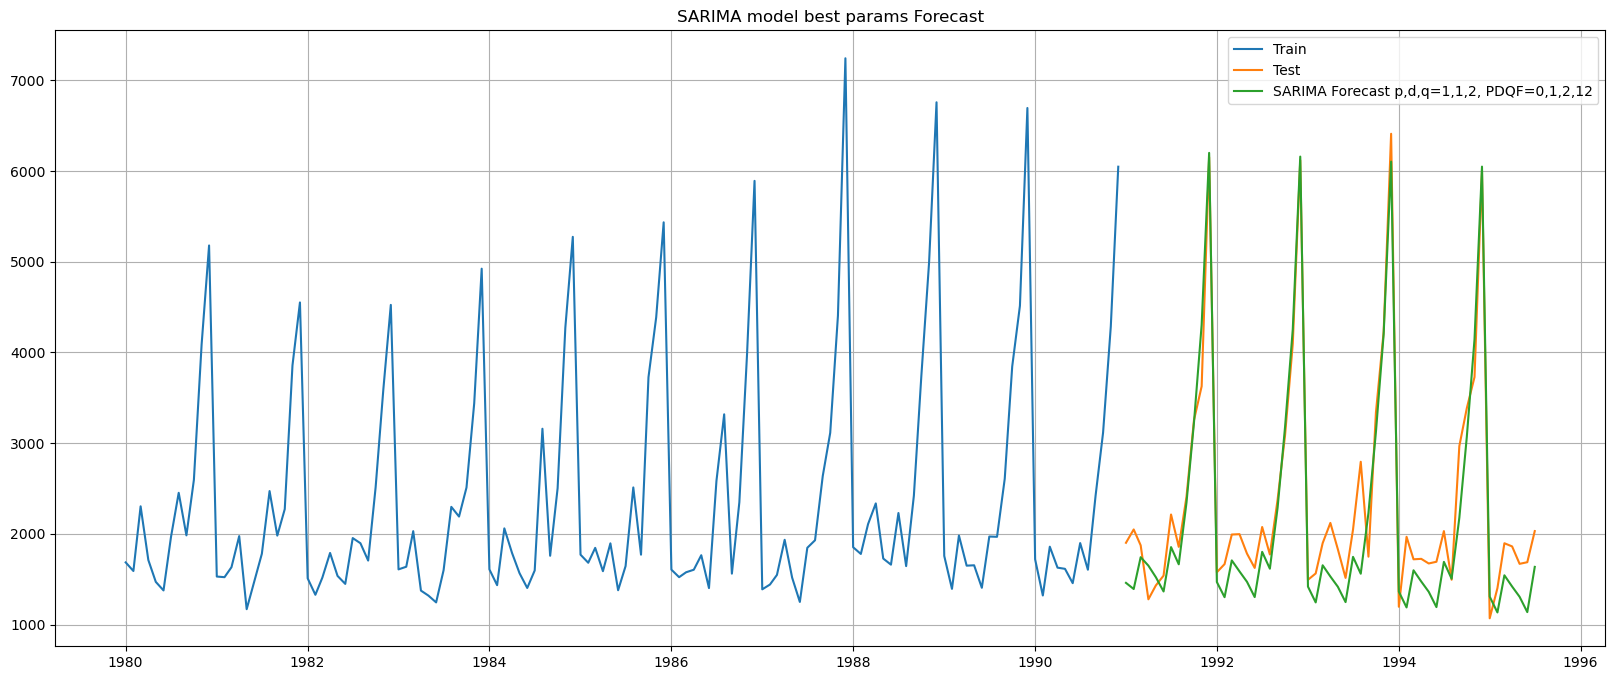

In [594]:
plt.plot(sarima_train['Sparkling'],label='Train')
plt.plot(sarima_test['Sparkling'],label='Test')
plt.plot(sarima_test['predictions'],label='SARIMA Forecast p,d,q=1,1,2, PDQF=0,1,2,12')
plt.title('SARIMA model best params Forecast')
plt.legend(loc='best')
plt.grid();

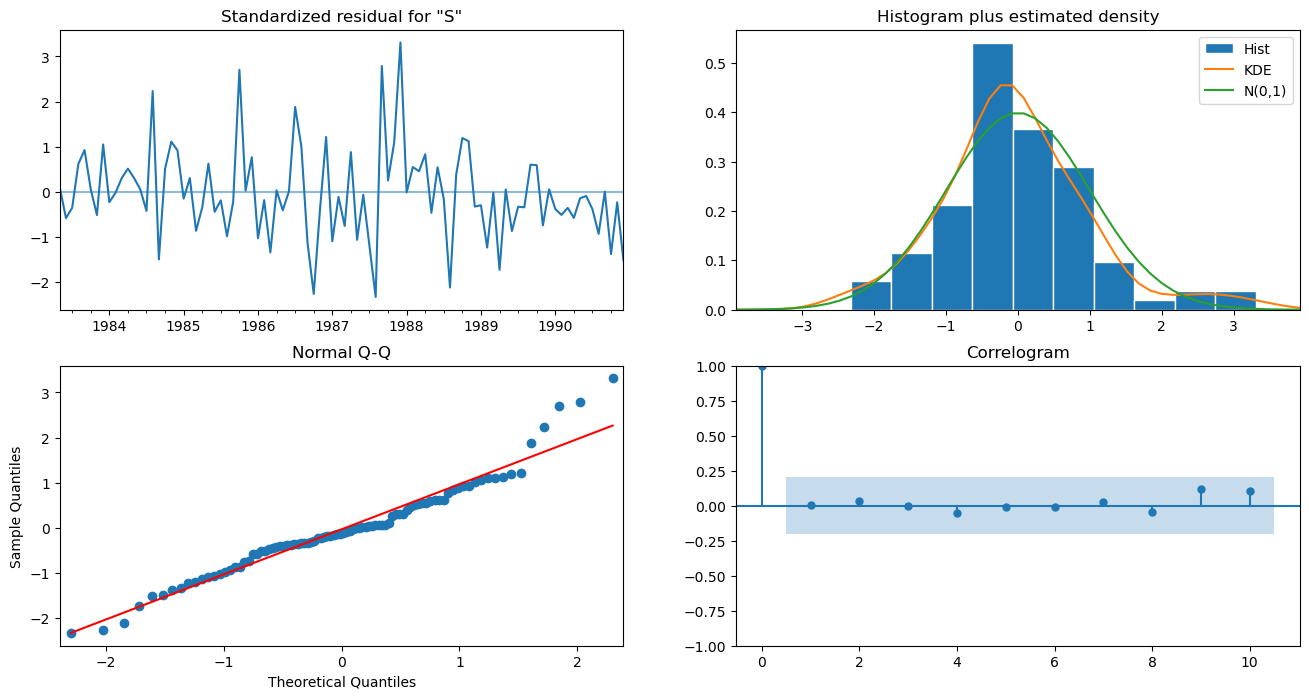

In [600]:
sarima_best_model.plot_diagnostics(figsize=(16, 8))
plt.show()

## Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [595]:
results_df

Test RMSE
LinearRegression                1389.14
NaiveForecast                   3864.28
SimpleAvgForecast               1275.08
MA_trail2                        813.40
MA_trail3                       1028.61
MA_trail6                       1283.93
MA_trail12                      1267.93
SimpleExpSmoothing              1304.93
SimpExpSmoothingAlpha0.01       1281.03
HoltAutofit                     2007.24
HoltBestAlphaBeta               1778.56
HoltWintersAutofit               378.95
HoltWintersalpha0.07gamma0.2     302.41
ARIMA                           1299.98
SARIMA                           382.58

In [596]:
results_df.sort_values(by='Test RMSE')

Test RMSE
HoltWintersalpha0.07gamma0.2     302.41
HoltWintersAutofit               378.95
SARIMA                           382.58
MA_trail2                        813.40
MA_trail3                       1028.61
MA_trail12                      1267.93
SimpleAvgForecast               1275.08
SimpExpSmoothingAlpha0.01       1281.03
MA_trail6                       1283.93
ARIMA                           1299.98
SimpleExpSmoothing              1304.93
LinearRegression                1389.14
HoltBestAlphaBeta               1778.56
HoltAutofit                     2007.24
NaiveForecast                   3864.28

Observations:
- From the above table, we can observe that the best model for the given time series is Holt Winters and SARIMA with appropriate params

## Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

### SARIMA

In [612]:
sarima_pred_99 = sarima_best_model.get_forecast(steps=12, alpha=0.01)## 99% confidence interval
sarima_pred_95 = sarima_best_model.get_forecast(steps=12, alpha=0.05) # alpha=0.05 95% CI

sarima_pred_ci_99 = sarima_pred_99.conf_int()
sarima_pred_ci_95 = sarima_pred_95.conf_int()

In [613]:
# n_steps = 36
idx = pd.date_range(start='1995-08-01',end='1996-07-01',freq='MS')
sarima_fc_95 = pd.DataFrame(np.column_stack([sarima_pred_95.predicted_mean, sarima_pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
sarima_fc_99 = pd.DataFrame(np.column_stack([sarima_pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
sarima_final = sarima_fc_95.combine_first(sarima_fc_99)
sarima_final = sarima_final[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']]

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
1995-08-01  1460.244612   650.930910  2269.558314   650.930910  2269.558314
1995-09-01  1392.437167   550.198950  2234.675384   550.198950  2234.675384
1995-10-01  1743.201679   900.288126  2586.115231   900.288126  2586.115231
1995-11-01  1650.066928   799.579757  2500.554099   799.579757  2500.554099
1995-12-01  1522.656011   671.555593  2373.756429   671.555593  2373.756429
1996-01-01  1365.342186   510.776688  2219.907684   510.776688  2219.907684
1996-02-01  1854.399118   998.232737  2710.565498   998.232737  2710.565498
1996-03-01  1664.797828   806.102891  2523.492765   806.102891  2523.492765
1996-04-01  2343.554274  1482.875329  3204.233219  1482.875329  3204.233219
1996-05-01  3223.021960  2360.076368  4085.967551  2360.076368  4085.967551
1996-06-01  4306.225031  3441.178861  5171.271201  3441.178861  5171.271201
1996-07-01  6199.418120  5332.189205  7066.647035  5332.189205  7066.647035

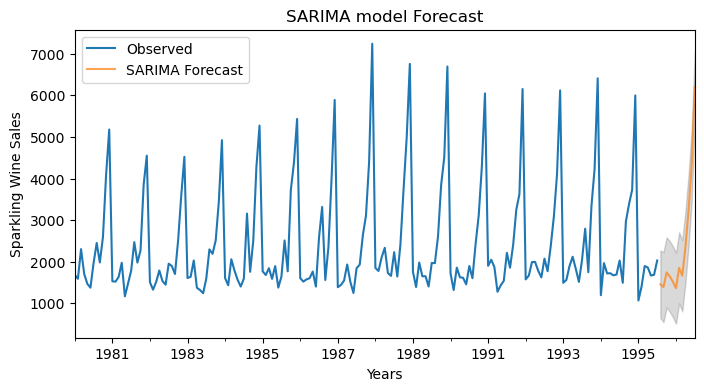

In [620]:
axis = sparkling_sales.plot(label='Observed', figsize=(8, 4))
sarima_final['forecast'].plot(ax=axis, label='SARIMA Forecast', alpha=0.7)
axis.fill_between(sarima_final.index, sarima_final['lower_ci_95'], sarima_final['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.title('SARIMA model Forecast')
plt.show()

### Holt-Winters Model

In [663]:
hw_forecast = hw_alpha_model.forecast(steps=12)

In [658]:
idx = pd.date_range(start='1995-08-01',end='1996-07-01',freq='MS')
idx

DatetimeIndex(['1995-08-01', '1995-09-01', '1995-10-01', '1995-11-01',
               '1995-12-01', '1996-01-01', '1996-02-01', '1996-03-01',
               '1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01'],
              dtype='datetime64[ns]', freq='MS')

In [659]:
hw_prediction_df=pd.DataFrame(np.column_stack([hw_forecast]),columns=['Sparkling forecast'],index=idx)

In [660]:
hw_prediction_df

Sparkling forecast
1995-08-01         1666.181613
1995-09-01         1494.847636
1995-10-01         1879.429774
1995-11-01         1799.937670
1995-12-01         1641.422462
1996-01-01         1464.847744
1996-02-01         1998.599509
1996-03-01         2171.527322
1996-04-01         2308.942666
1996-05-01         3191.219129
1996-06-01         4334.987357
1996-07-01         6043.996156

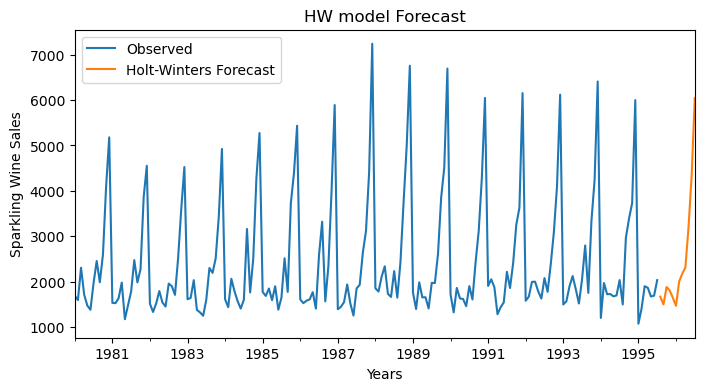

In [661]:
axis = sparkling_sales.plot(label='Observed', figsize=(8, 4))
hw_prediction_df['Sparkling forecast'].plot(ax=axis, label='Holt-Winters Forecast')
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.title('HW model Forecast')
plt.show()

## Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.

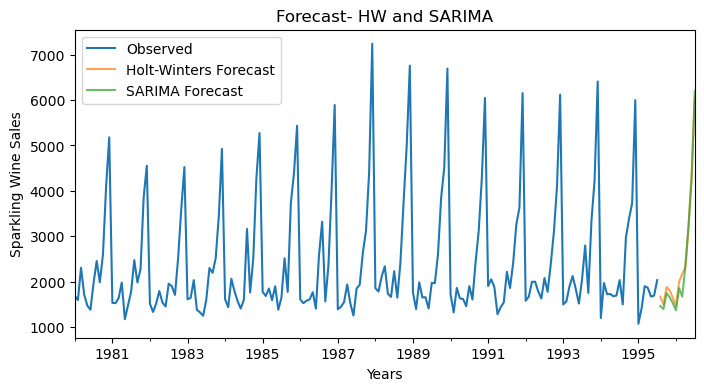

In [666]:
axis = sparkling_sales.plot(label='Observed', figsize=(8, 4))
hw_prediction_df['Sparkling forecast'].plot(ax=axis, label='Holt-Winters Forecast',alpha=0.7)
sarima_final['forecast'].plot(ax=axis, label='SARIMA Forecast', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.title('Forecast- HW and SARIMA')
plt.show()

Observations:
- The wine sales peaks during the months of November and december, probably due to the holiday season. 
- The sales data does not exhibit any trend

Insights:
- The seasonality component of sales can be capitalized, and can try to push sales in the peak months
- The trend component needs improvement. The company can adopt different marketing strategies by customer segmentation in order to increase the overall trend